In [23]:
import matplotlib
matplotlib.use('PS')
%matplotlib inline

# SAIO vs GEQO comparison - report

## Introduction

This is an aggregated report on comparison of two alternative join order optimizers:

* GEQO - Genetic Query Optimizer (current default optimizer in Postgres)
* SAIO - Simulated Annealing based Join Order optimizer (PGXN extension for Postgres)

The tests compare query costs, optimizing time and memory used.

## Methodology
GEQO and SAIO are tested on many different schemas and queries. To ensure proper representation of each join order optimizer abilities, each query has been tested on a range of parameters:

* GEQO has been tested with GEQO effort in range 0 to 10
* SAIO has been tested with different combinations of: 
    * equilibrium factor (explain what is this)
    * temperature reduction (temperature is multiplied by this fraction in each iteration until the system freezes)

Some parameters of SAIO were fixed to reduce testing time:

* initial temperature (explain)
* steps before freeze (explain)

FROM_COLLAPSE_LIMIT and JOIN_COLLAPSE_LIMIT have been set to 200.


## Testing data
The testing data (DB schemas and queries) has been divided into following sections:

### Provided data
SQL scripts that were written by hand. Mostly for the previous iteration of SAIO.

### Programatically generated data
SQL scripts automatically generated by Python scripts

Schemas:

* 20-200 tables without constraints
* 20-200 tables with constraints


Flat queries:

* 15-20 JOINS (JOINS, LEFT JOINS, RIGHT JOINS)
* 20-30 JOINS
* 30-50 JOINS
* 50-70 JOINS
* 70-100 JOINS
* 100+ JOINS

Nested queries:

* 15-20 JOINS
* 20-30 JOINS
* 30-50 JOINS
* 50-70 JOINS
* 70-100 JOINS
* 100+ JOINS

### Industrial examples
This would be awesome to include such examples. No examples yet.


#Test summary

//Graph summarising the GEQO/SAIO performance comparison results.

#Conclusions

This report presents the behaviour of SAIO and GEQO for a number of queries. It doesn't show superiority of SAIO however it indicates that SAIO is worth further development and can possibly replace GEQO for more complicated queries.

There is number of cases where SAIO outperforms GEQO in terms of estimated total query cost. Unfortunately SAIO often produces worse results in terms of total cost, used memory and optimizing time.

##Cases where GEQO clearly wins:

In these cases GEQO constantly creates plans with lower cost, needs less time and memory.

* Queries with cartesian joins such as:
    ```sql
    SELECT * FROM tab_1, tab_2 ... tab_N 
        WHERE (tab_1.col_1 = tab_2.col_1) AND (..) AND (tab_1.col_1 = tab_N.col_1);
    ```  

* Queries with many JOINS and LEFT JOINS such as:
    ```sql
    SELECT * FROM tab_1 
        [LEFT]JOIN tab_2 on tab_1.col_1 = tab_2.col_2
        ...
        [LEFT]JOIN tab_N on tab_N.col_X = tab_Y.col_Z;
    ```

##Cases where SAIO wins

Here we can observe that SAIO constantly finds solutions with lower cost.

* Queries with many RIGHT JOINS such as:
    ```sql
    SELECT * FROM tab_1 
        RIGHT JOIN tab_2 on tab_1.col_1 = tab_2.col_2
        ...
        RIGHT JOIN tab_N on tab_N.col_X = tab_Y.col_Z;
    ```
* Nested queries:
    ```sql
        SELECT * FROM tab_1 
        [LEFT/RIGHT/] JOIN (
            SELECT * FROM tab_2
                [LEFT/RIGHT/] JOIN tab_3.col_A = tab_2.col_B
                ...
                [LEFT/RIGHT/] JOIN tab_W.col_X = tab_Y.col_Z
        ) AS subquery_1 ON TRUE     
        ...
        [LEFT/RIGHT/] JOIN (
        ) AS subquery_N ON TRUE;
        
    ```

This benchmark should be treated with a grain of salt as it doesn't cover all the possible cases (it can be improved with some suggestions). For a production system, join order optimizer should be chosen after checking it's performance on a few example queries.

# Test details
In this section one can find more detailed information about the testing process - schemas and queries used. Also graphs that highlight performance of each of the algorithms.

In [20]:
import matplotlib.pyplot as plt # side-stepping mpl backend
from pylab import *
import numpy as np


def plot_geqo_against_average_saio(results_saio, results_geqo, title):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(19,4))
    
    axes[0].plot(results_geqo[:,0], results_geqo[:,4], label="geqo cost")
    axes[0].plot(results_geqo[:,0],[np.average(results_saio[:,4])]*len(results_geqo[:,4]), label="average saio cost")
    axes[0].set_xlabel('geqo effort')
    axes[0].set_ylabel('cost')
    axes[0].set_title(title)
    axes[0].legend()
    
    axes[1].plot(results_geqo[:,0], results_geqo[:,5], label="geqo time")
    axes[1].plot(results_geqo[:,0],[np.average(results_saio[:,5])]*len(results_geqo[:,5]), label="average saio time")
    axes[1].set_xlabel('geqo effort')
    axes[1].set_ylabel('time [s]')
    axes[1].set_title(title)
    axes[1].legend()
    
    axes[2].plot(results_geqo[:,0], results_geqo[:,6]/1000, label="geqo memory")
    axes[2].plot(results_geqo[:,0],[np.average(results_saio[:,6])/1000]*len(results_geqo[:,6]), label="average saio memory")
    axes[2].set_xlabel('geqo effort')
    axes[2].set_ylabel('memory [MB]')
    axes[2].set_title(title)
    axes[2].legend()
    plt.show()
    

def plot_comparison(results_saio, results_geqo, title):   
    labels = ['GEQO', 'SAIO']
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(19,4))
    axes[0].boxplot((results_geqo[:,4], results_saio[:,4]), labels=labels, showmeans=True)
    axes[0].set_ylabel('Cost []')
    axes[0].grid(True)

    axes[1].boxplot((results_geqo[:,5], results_saio[:,5]), labels=labels, showmeans=True)
    axes[1].set_ylabel('Optimizing time [s]')
    axes[1].grid(True)

    axes[2].boxplot((results_geqo[:,6]/1000, results_saio[:,6]/1000), labels=labels, showmeans=True)
    axes[2].set_ylabel('Memory usage [MB]')
    axes[2].grid(True)
    
    fig.suptitle(title, fontsize='15')
    plt.show()
    
def plot_space(results_saio, results_geqo):
    geqo_avg_cost = np.average(results_geqo[:,4])
    geqo_avg_time = np.average(results_geqo[:,5])
    geqo_avg_memory = np.average(results_geqo[:,6])

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    
    X, Y = results_saio[:,0], results_saio[:,2]
    cost, time, memory = results_saio[:,4], results_saio[:,5], results_saio[:,6]
    
    plt.subplot(1,3,1)
    #print len(cost)
    cost = cost.reshape(9, 11) / geqo_avg_cost
    im_cost = plt.imshow(cost, extent=(X.min(), X.max(), Y.max(), Y.min()),
           interpolation='nearest', cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('equilibrium factor')
    plt.ylabel('temperature reduction factor')
    plt.colorbar(im_cost)
    plt.title('SAIO cost / avg(GEQO cost)')
    plt.grid(True)
    
    plt.subplot(1,3,2)
    time = time.reshape(9, 11) / geqo_avg_time
    im_time = plt.imshow(time, extent=(X.min(), X.max(), Y.max(), Y.min()),
           interpolation='nearest', cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('equilibrium factor')
    plt.ylabel('temperature reduction factor')
    plt.colorbar(im_time)
    plt.title('SAIO time / avg(GEQO time) [s/s]')
    plt.grid(True)
   
    plt.subplot(1,3,3)
    memory = (memory.reshape(9, 11)/1000) / (geqo_avg_memory/1000)
    im_memory = plt.imshow(memory, extent=(X.min(), X.max(), Y.max(), Y.min()),
           interpolation='nearest', cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('equilibrium factor')
    plt.ylabel('temperature reduction factor')
    plt.colorbar(im_memory)
    plt.title('SAIO memory / avg(GEQO memory) [MB/MB]')
    plt.grid(True)
    plt.show()
    

def display_info_for_test_case(test_case_name):
    #with open('benchmarks/'+test_case_name, 'r') as f:
    #    print f.read()
        
    #equilibrium_factor, initial_temperature, temperature_reduction_factor, steps_before_frozen, cost, time, memory
    results_saio = np.loadtxt("benchmarks/current_output/"+test_case_name + '.saio.out')
    #geqo_effort, geqo_pool_size, geqo_generations, geqo_selection_bias, cost, time, memory
    results_geqo = np.loadtxt("benchmarks/current_output/"+test_case_name + '.geqo.out')

    plot_comparison(results_saio, results_geqo, test_case_name)
    plot_geqo_against_average_saio(results_saio, results_geqo, 'GEQO vs SAIO ' + test_case_name)
    plot_space(results_saio, results_geqo)

## Provided queries
These queries were provided to test the previous iteration of SAIO back in 2010.

### MODERATELY COMPLEX QUERY

This query was provided to test the previous iteration of SAIO back in 2010. 
![no photo](static/schemasql.png "Logo Title Text 1")

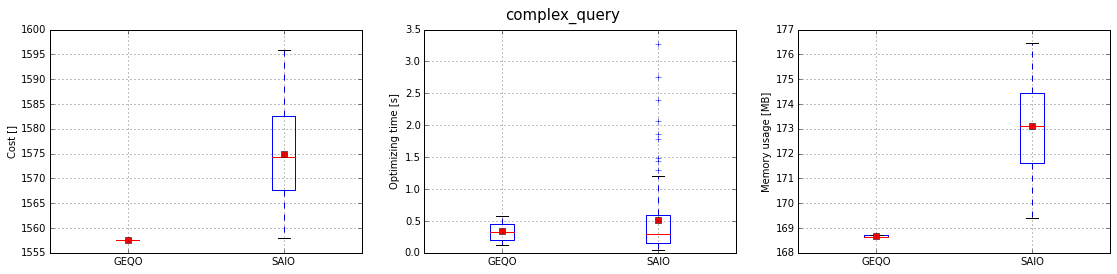

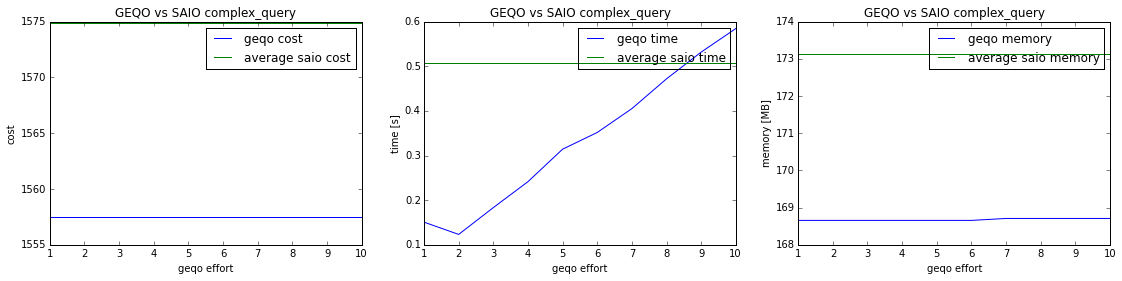

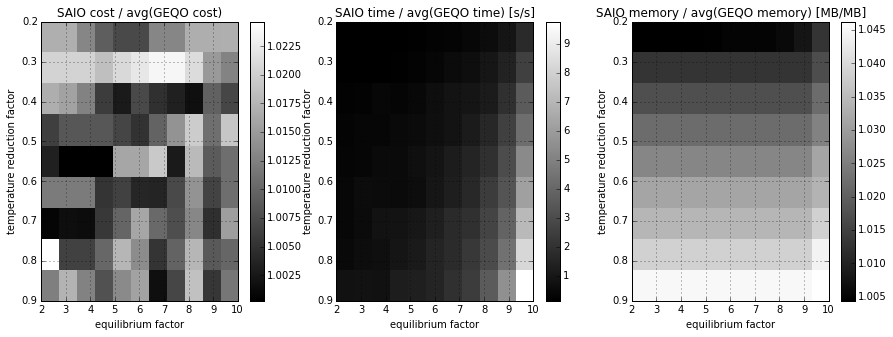

In [21]:
display_info_for_test_case('complex_query')

### COMPLEX QUERY

Here SAIO clearly outperforms GEQO finding join order with lower cost in shorter time.

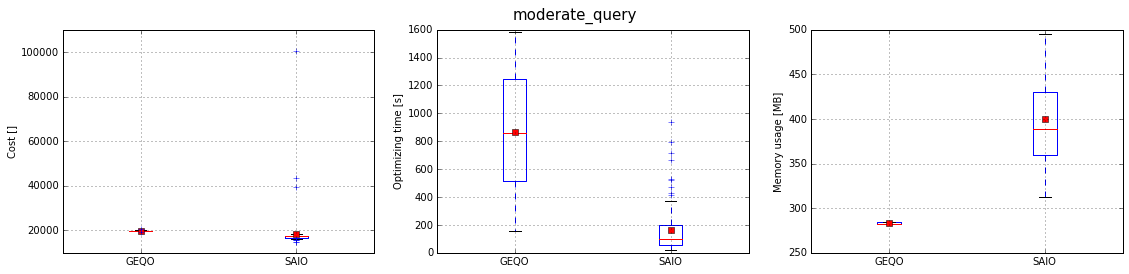

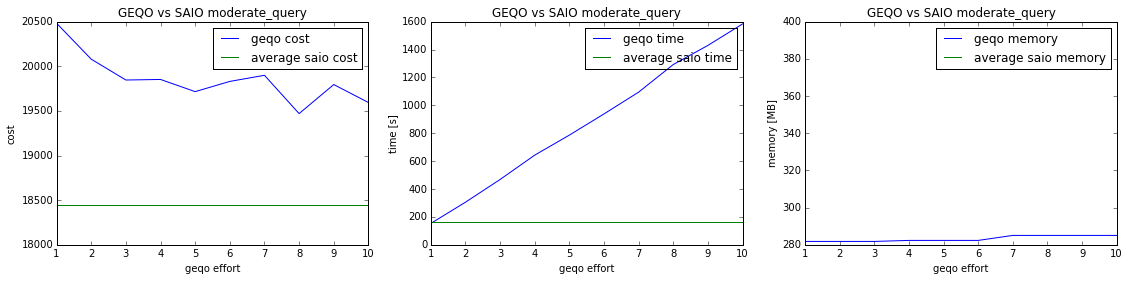

99


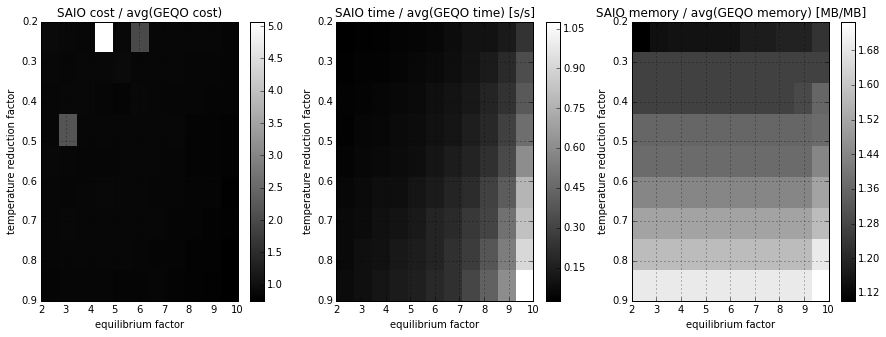

In [4]:
display_info_for_test_case('moderate_query')

Description

## Programatically generated queries

### star query - cartesians

No constraints, 30 arms

//query

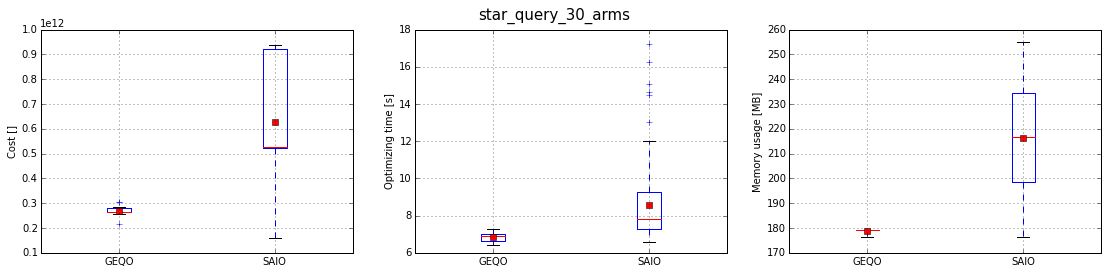

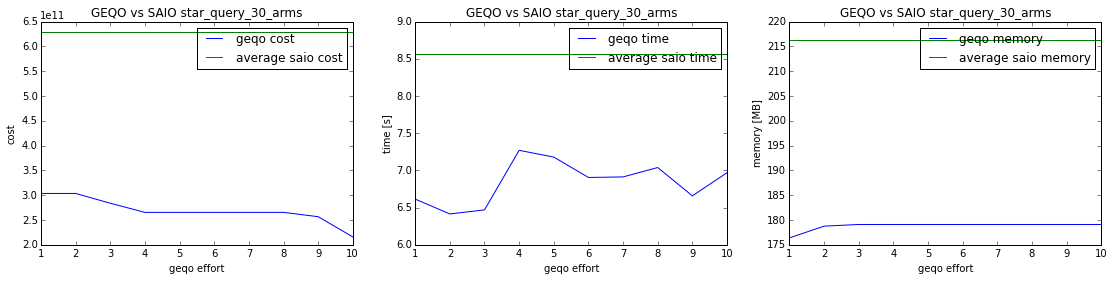

99


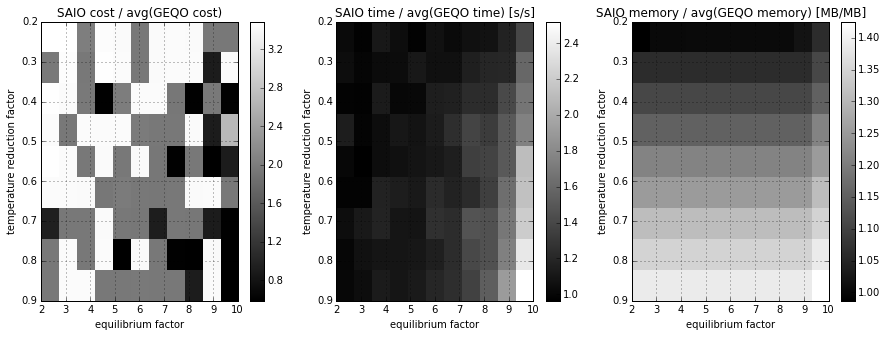

In [5]:
display_info_for_test_case('star_query_30_arms')

No constraints 50 arms

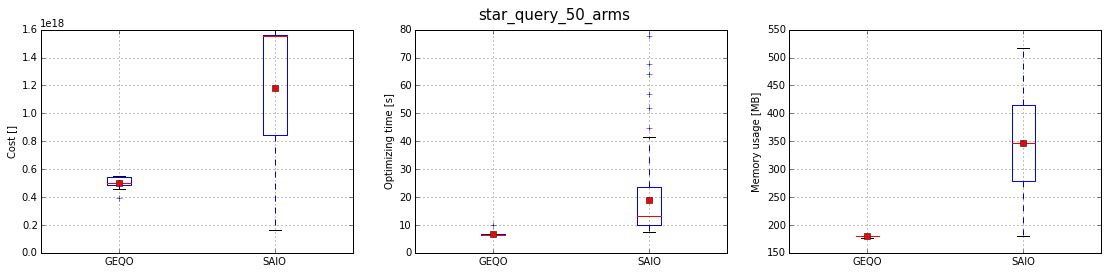

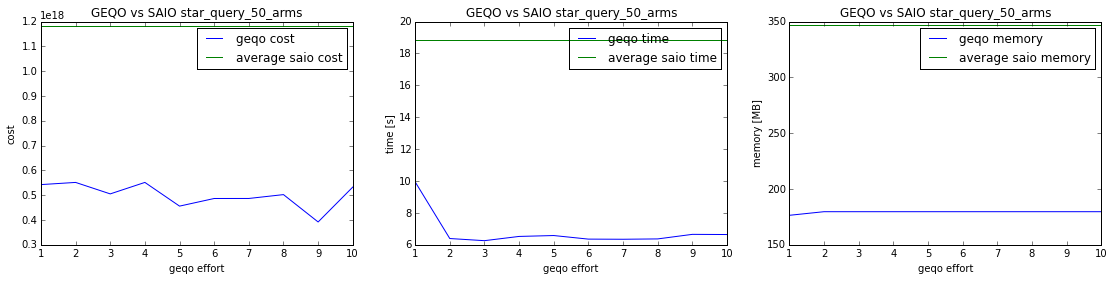

99


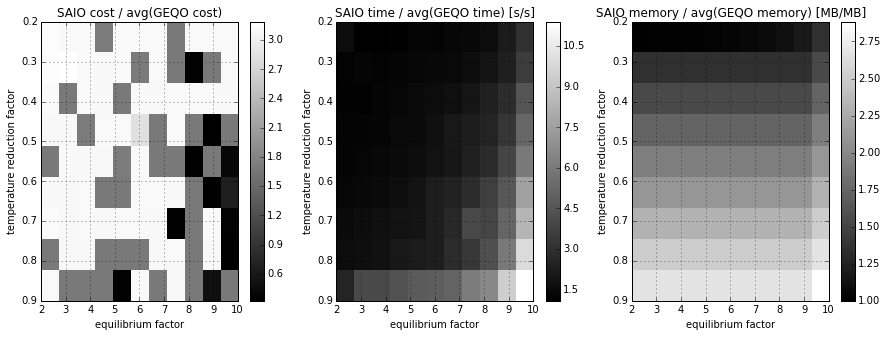

In [6]:
display_info_for_test_case('star_query_50_arms')

No constraints 80 arms

//query

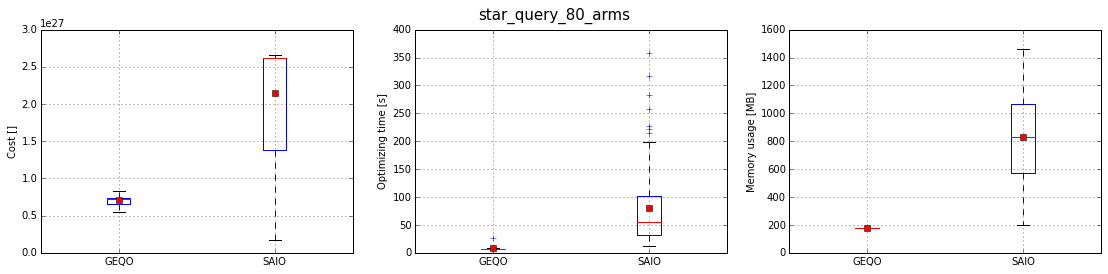

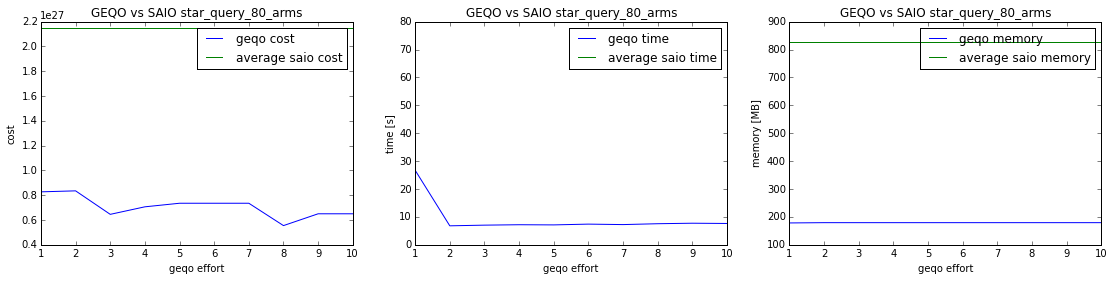

99


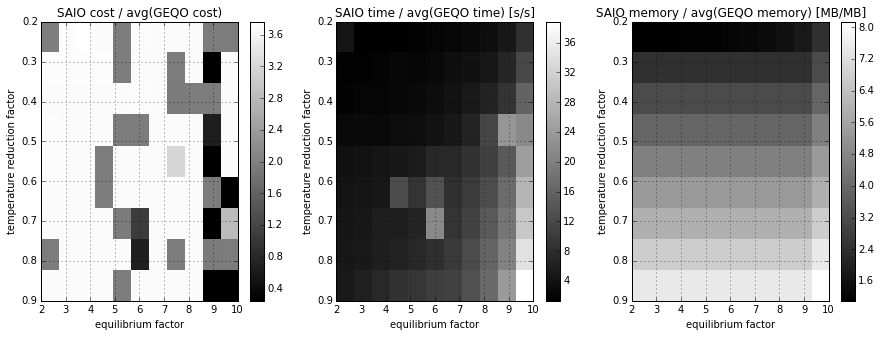

In [7]:
display_info_for_test_case('star_query_80_arms')

No constraints 150 arms

## star query - joins

30 arms

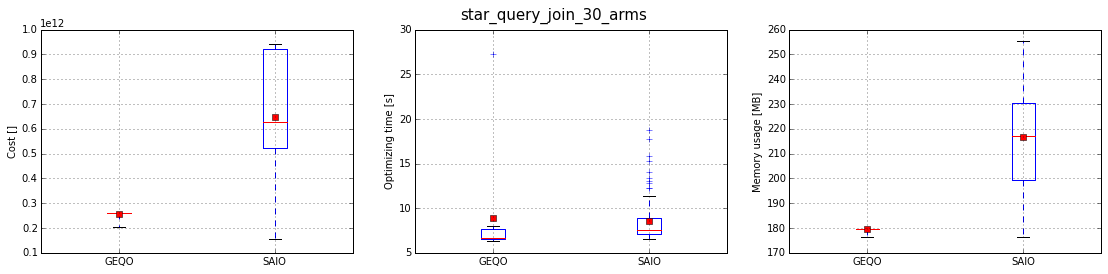

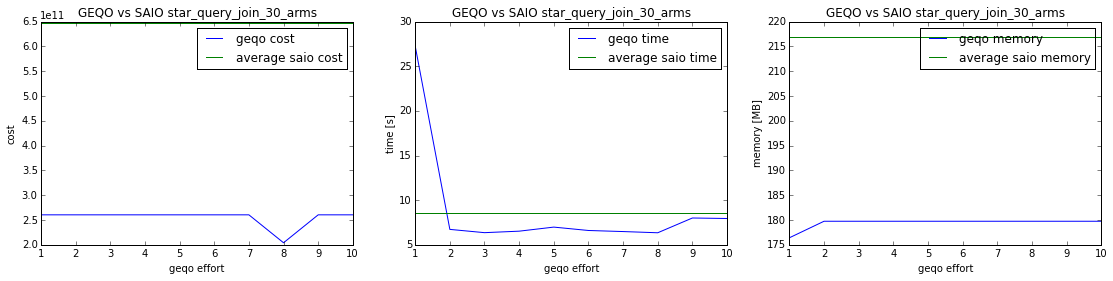

99


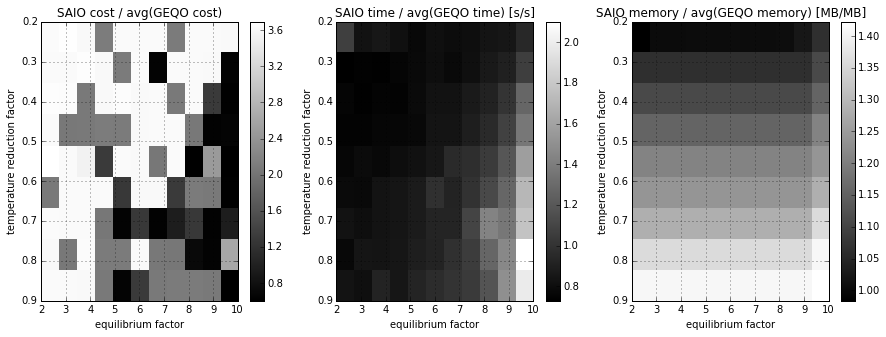

In [8]:
display_info_for_test_case('star_query_join_30_arms')

50 arms

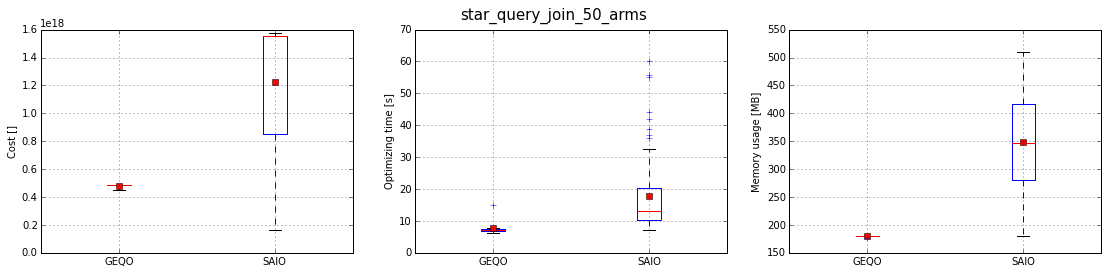

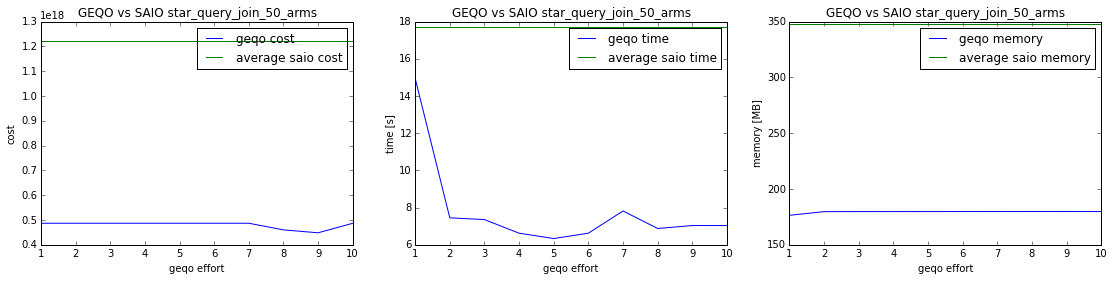

99


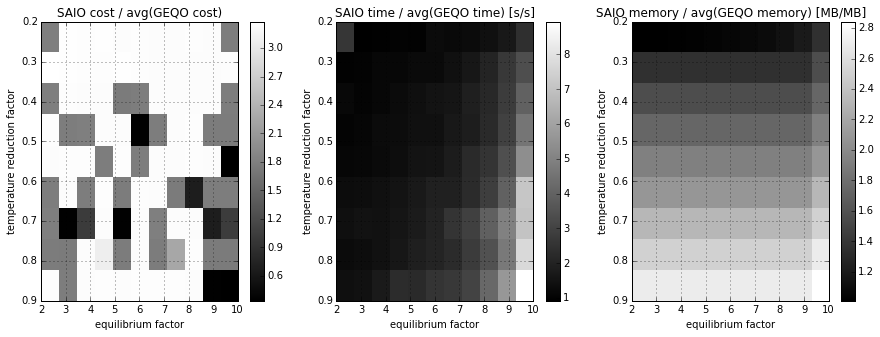

In [9]:
display_info_for_test_case('star_query_join_50_arms')

### flat queries

15 JOINS (JOINS, LEFT JOINS, RIGHT JOINS)

In [25]:
display_info_for_test_case('random_query_15_joins_no_constraints')
display_info_for_test_case('random_query_15_left_joins_no_constraints')
display_info_for_test_case('random_query_15_right_joins_no_constraints')
display_info_for_test_case('random_query_5_joins_5_left_5_right')

IOError: [Errno 2] No such file or directory: 'benchmarks/current_output/random_query_15_joins_no_constraints.saio.out'

20 JOINS

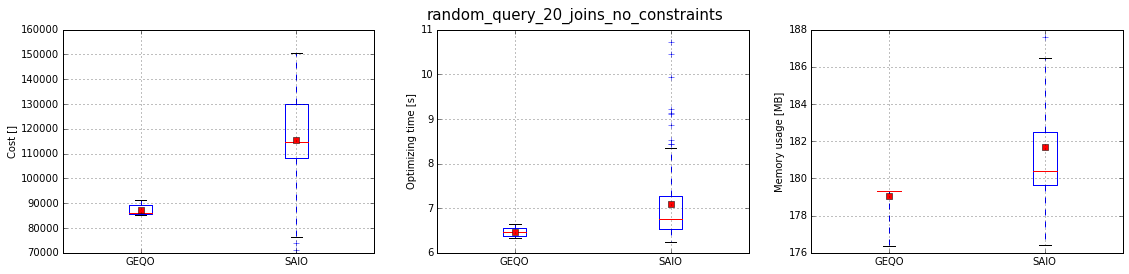

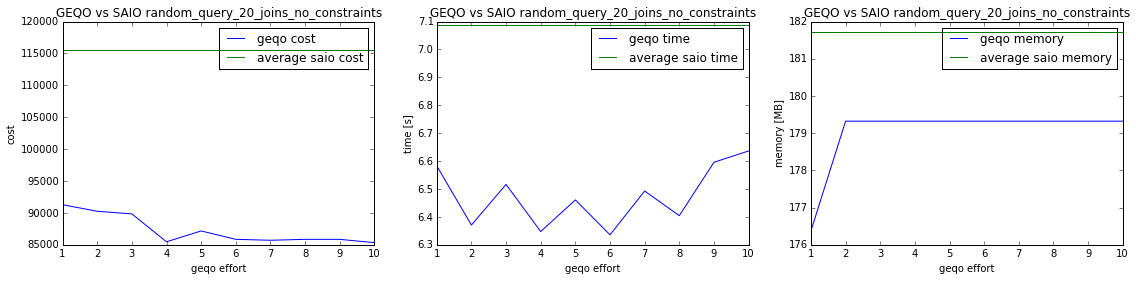

99


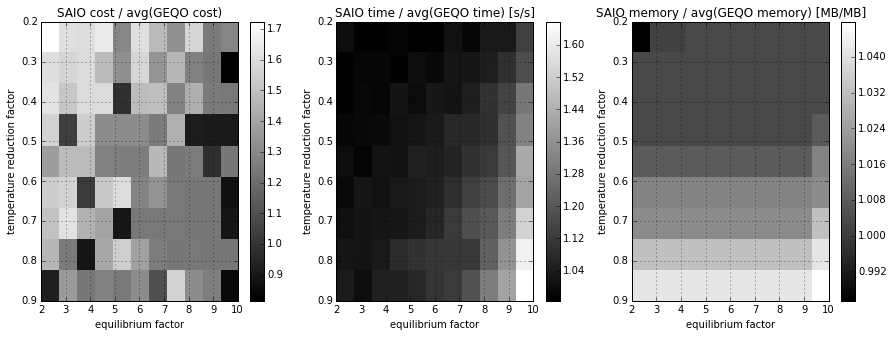

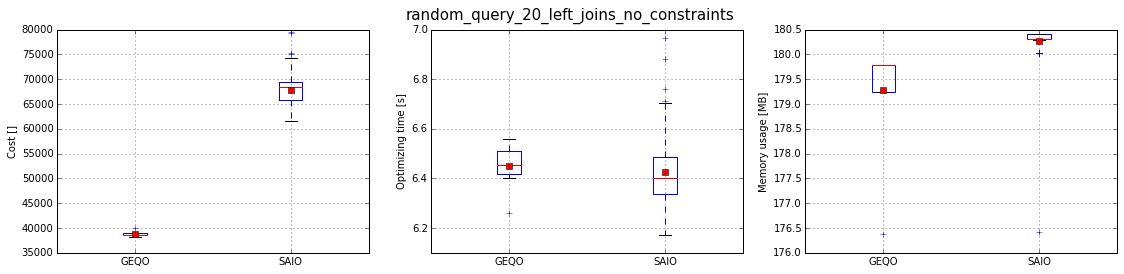

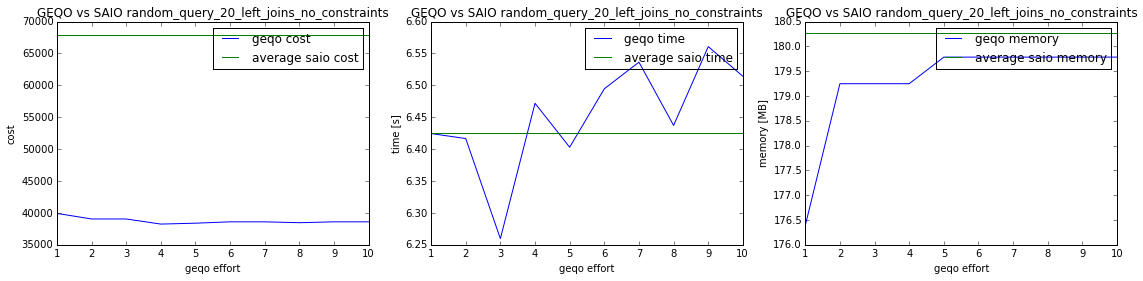

99


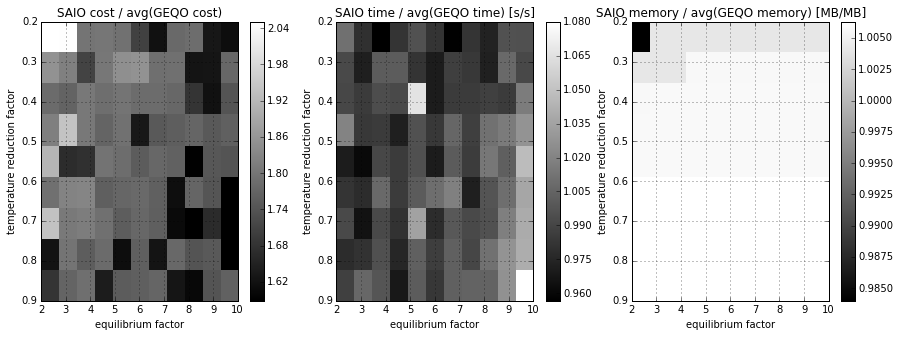

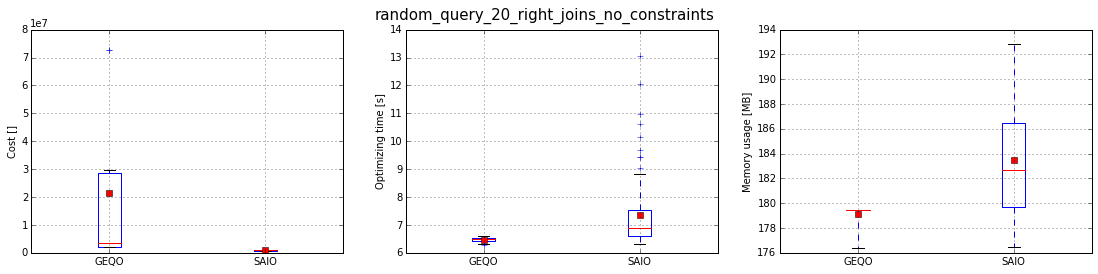

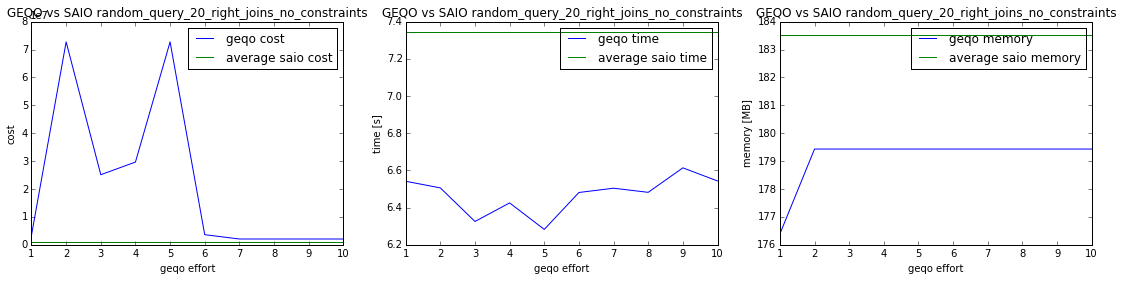

99


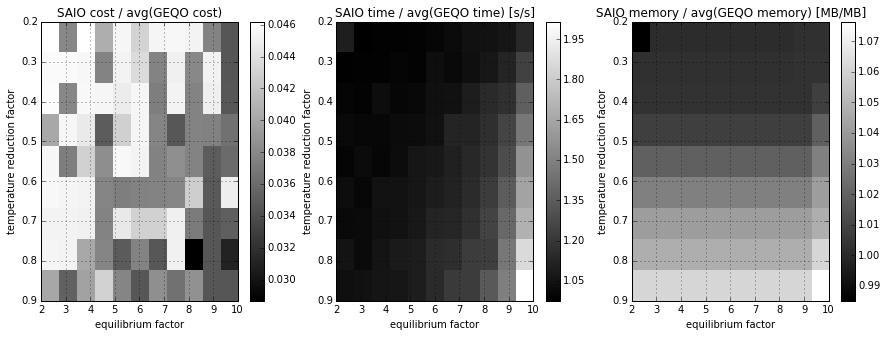

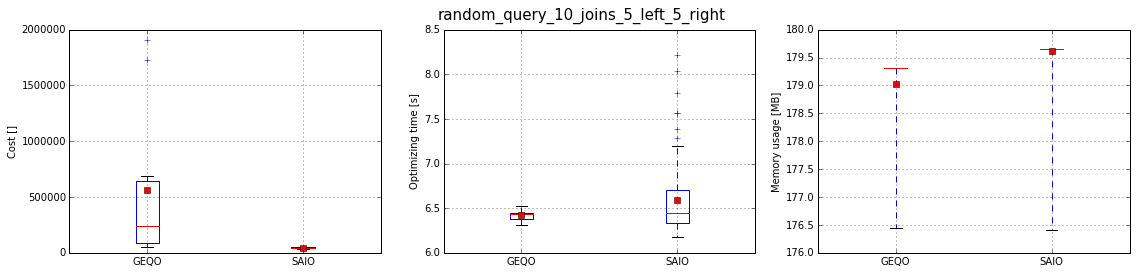

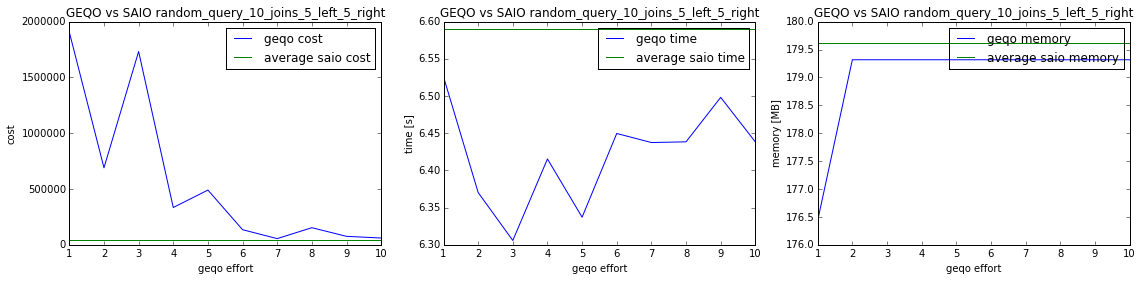

99


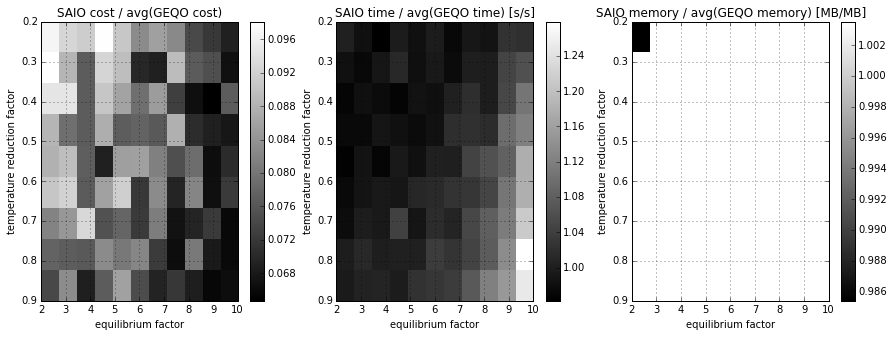

In [11]:
display_info_for_test_case('random_query_20_joins_no_constraints')
display_info_for_test_case('random_query_20_left_joins_no_constraints')
display_info_for_test_case('random_query_20_right_joins_no_constraints')
display_info_for_test_case('random_query_10_joins_5_left_5_right')

30 JOINS

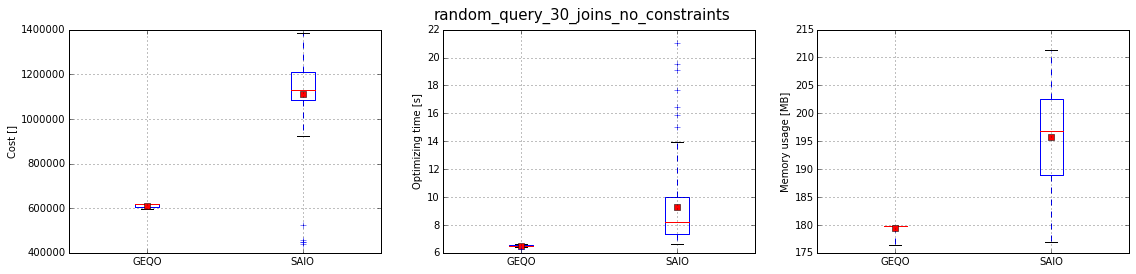

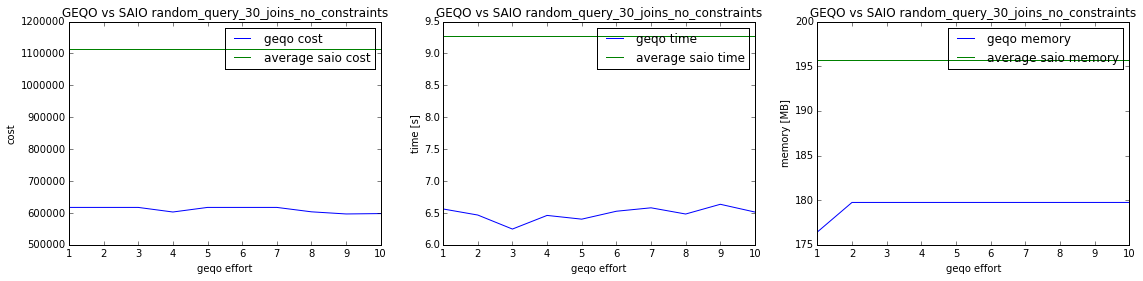

99


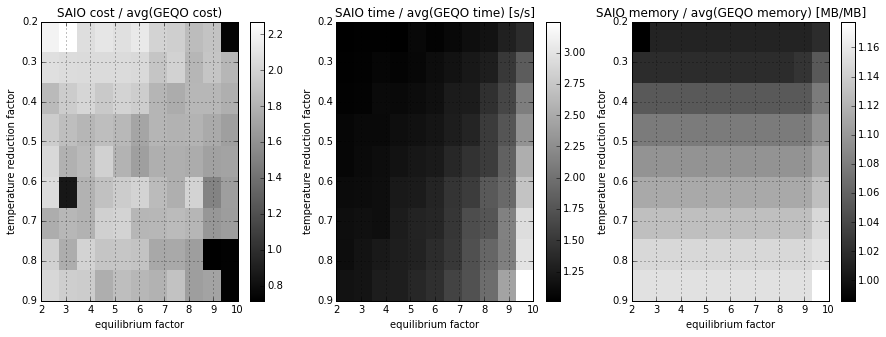

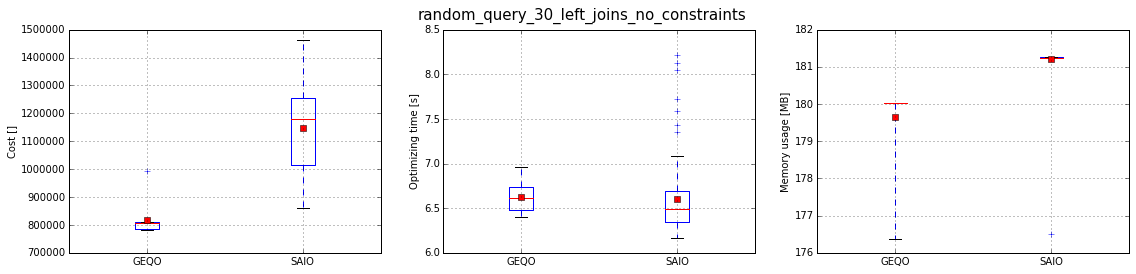

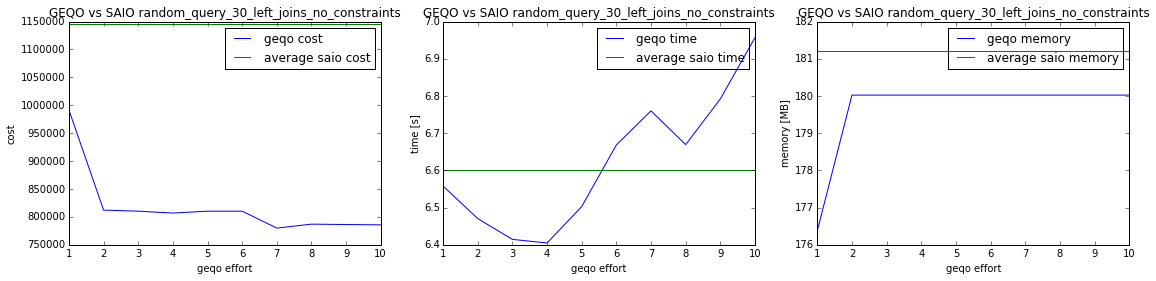

99


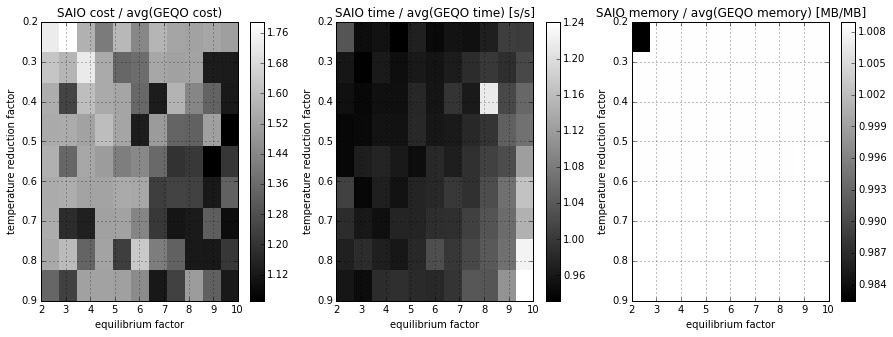

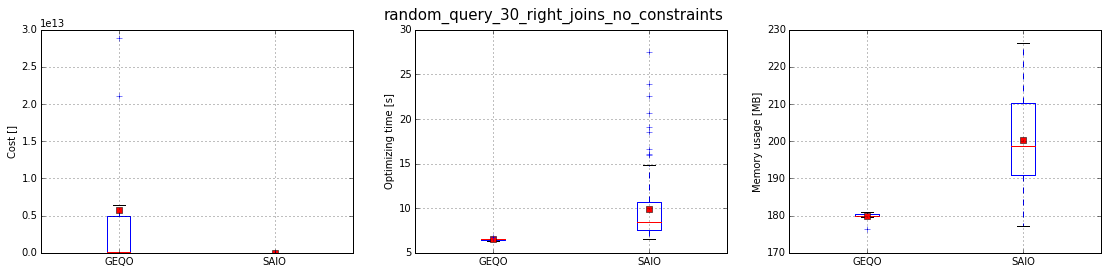

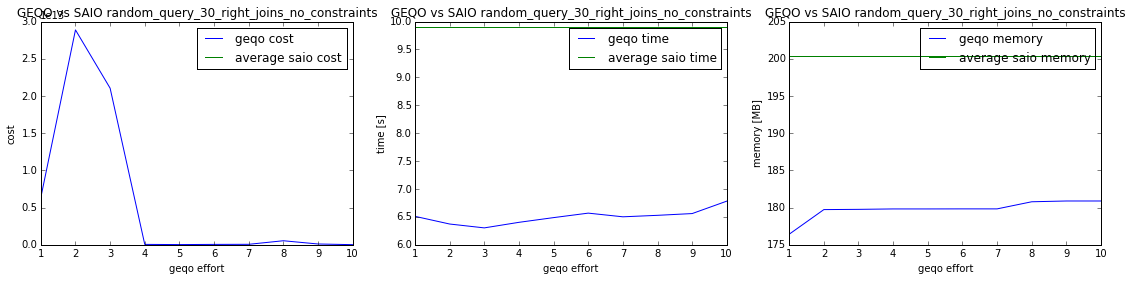

99


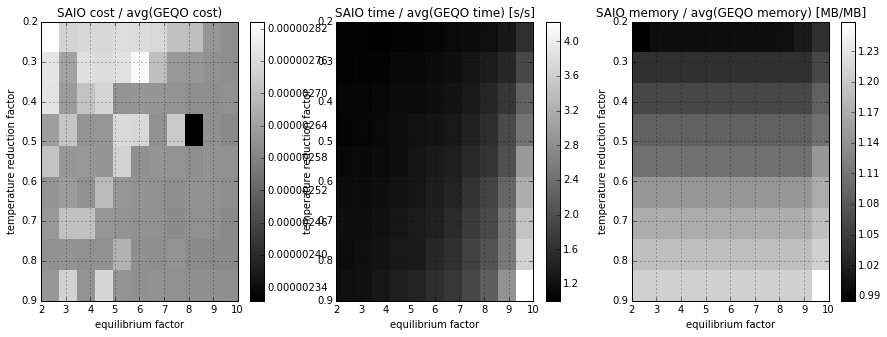

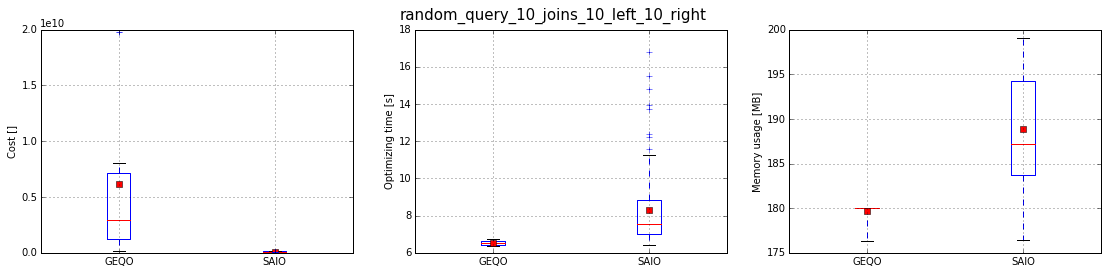

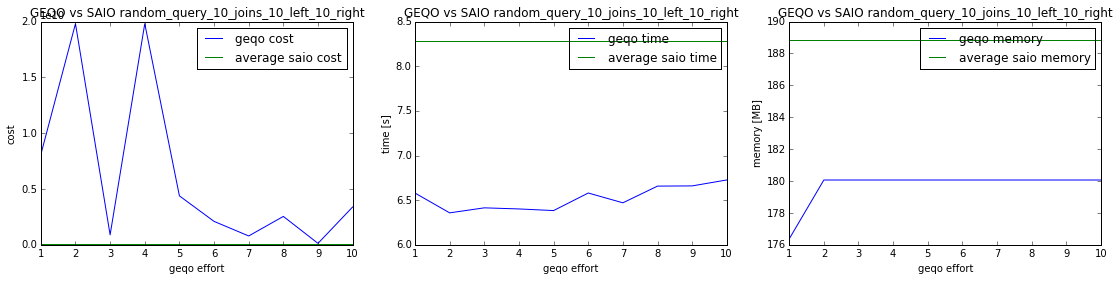

99


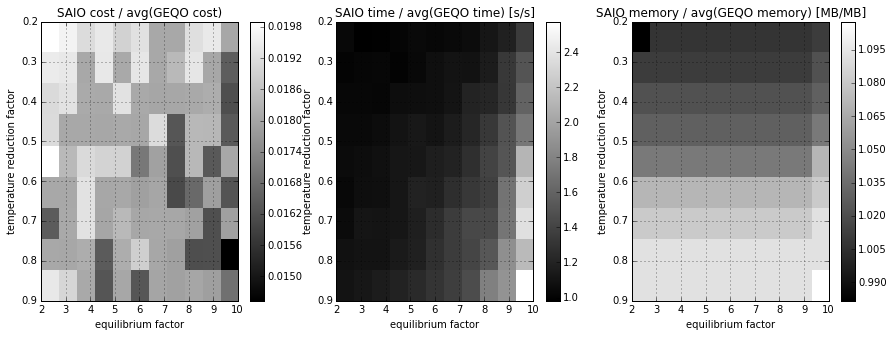

In [12]:
display_info_for_test_case('random_query_30_joins_no_constraints')
display_info_for_test_case('random_query_30_left_joins_no_constraints')
display_info_for_test_case('random_query_30_right_joins_no_constraints')
display_info_for_test_case('random_query_10_joins_10_left_10_right')

####50 JOINS

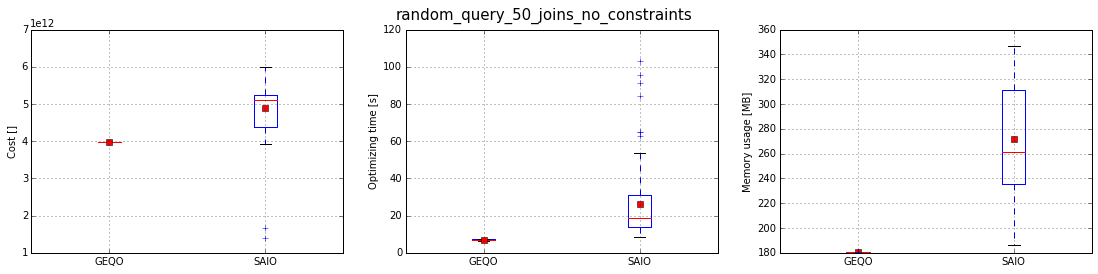

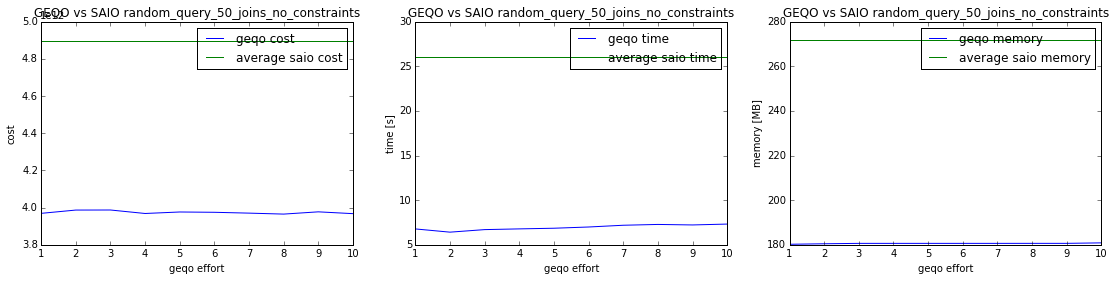

99


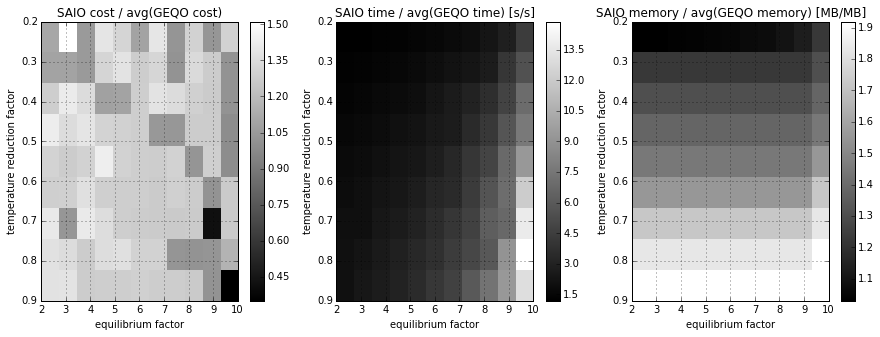

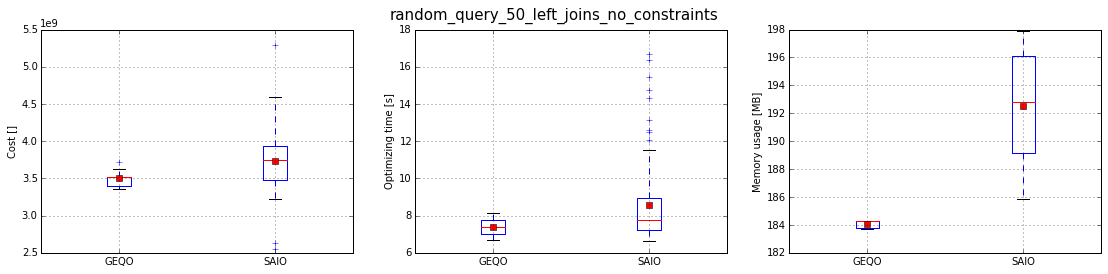

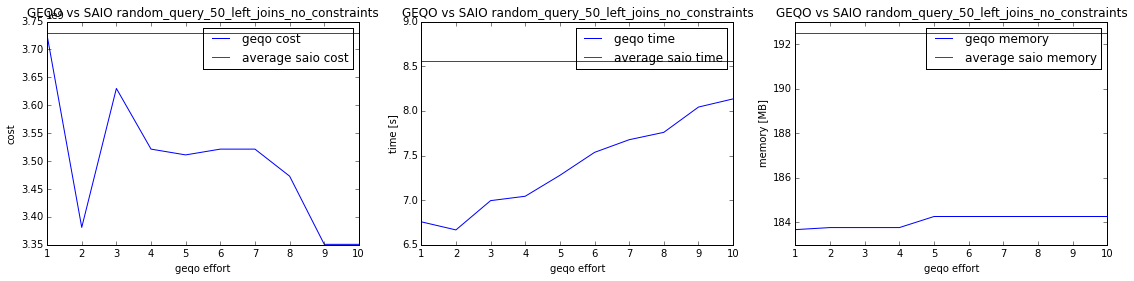

99


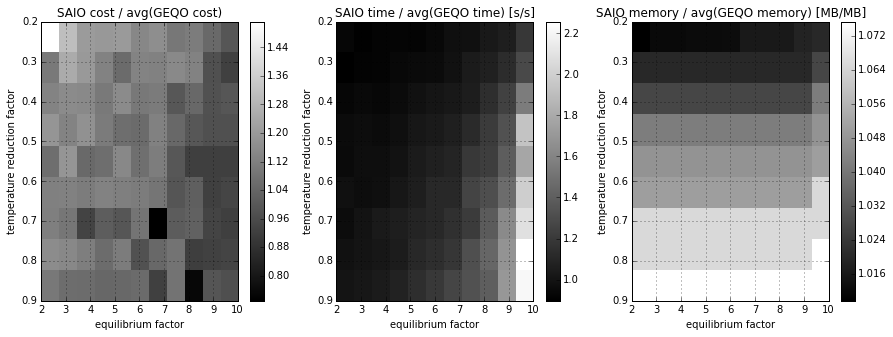

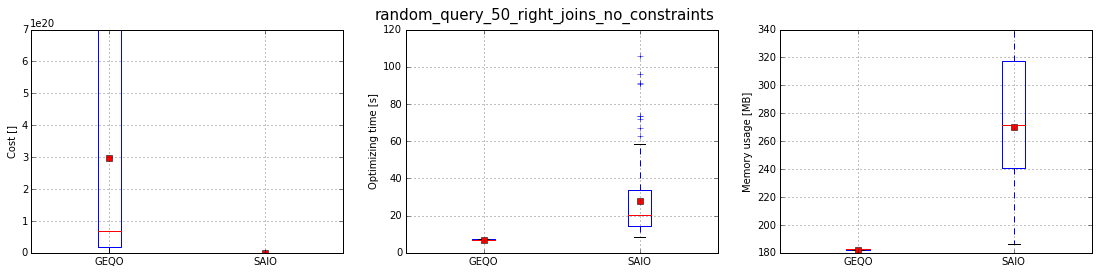

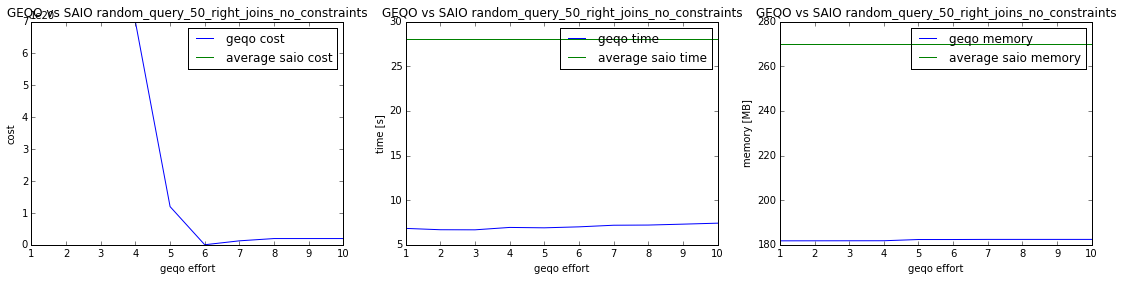

99


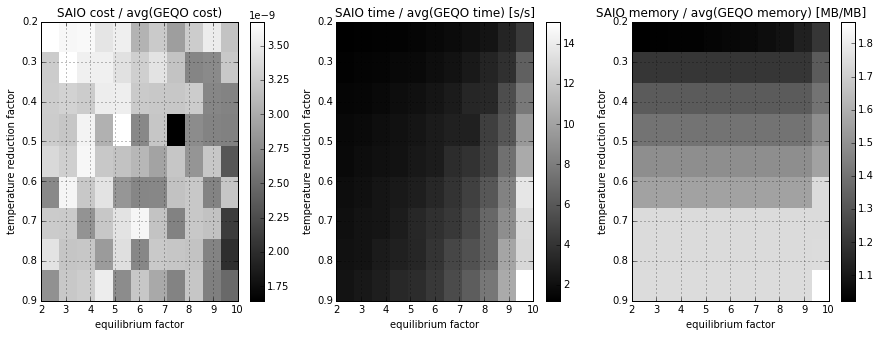

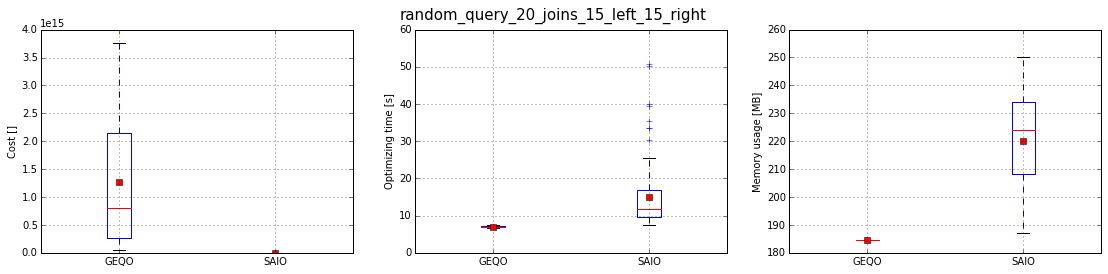

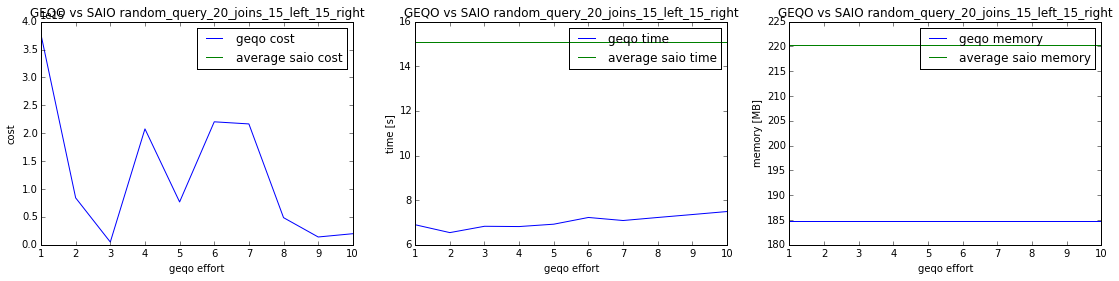

99


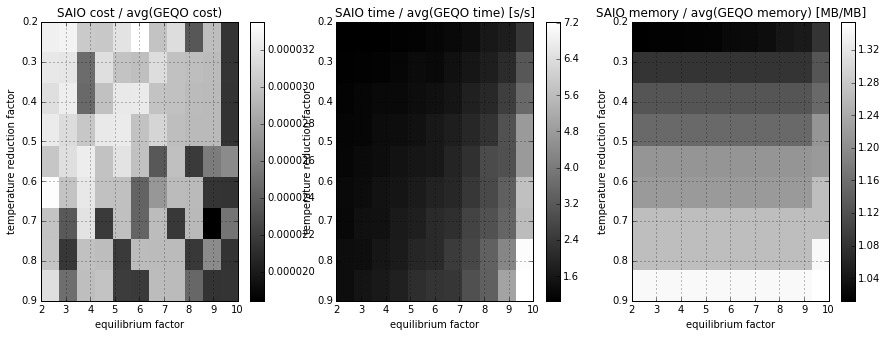

In [13]:
display_info_for_test_case('random_query_50_joins_no_constraints')
display_info_for_test_case('random_query_50_left_joins_no_constraints')
display_info_for_test_case('random_query_50_right_joins_no_constraints')
display_info_for_test_case('random_query_20_joins_15_left_15_right')

####70 JOINS

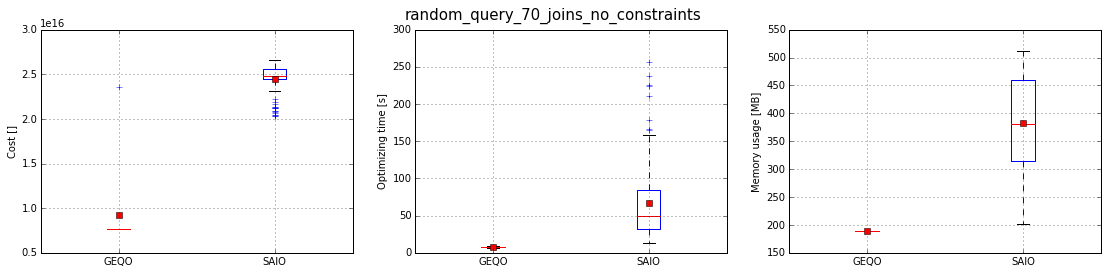

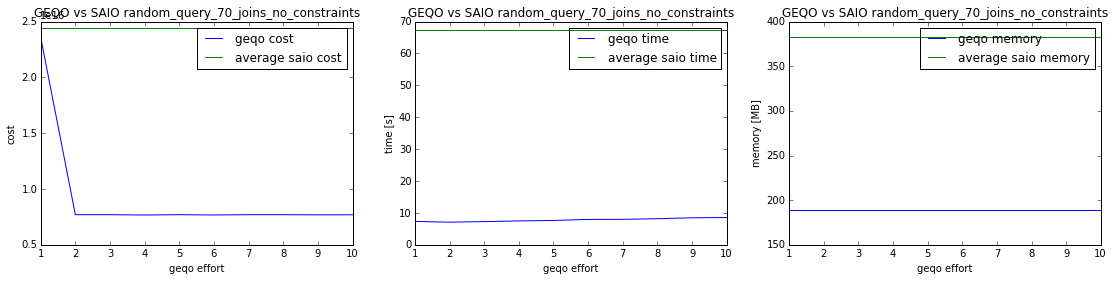

99


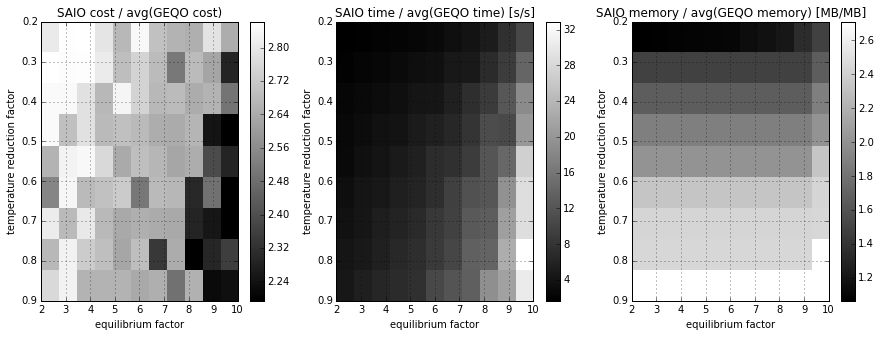

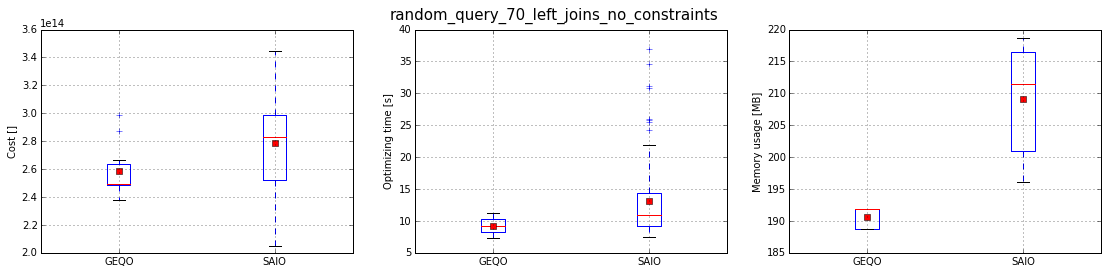

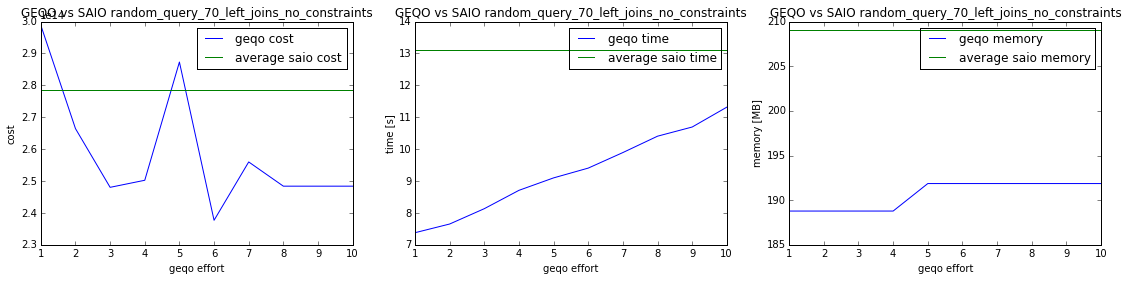

99


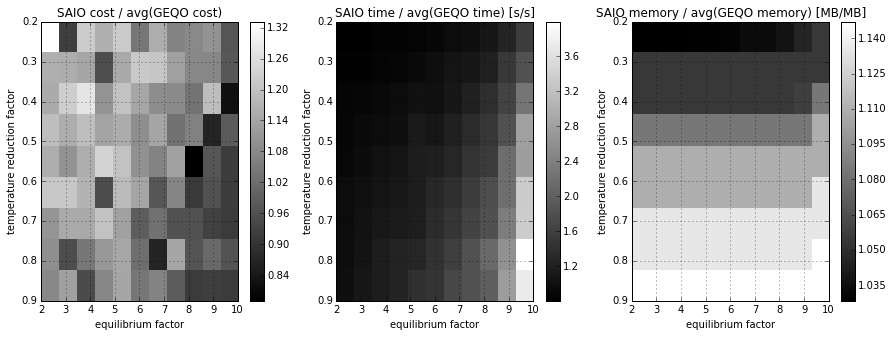

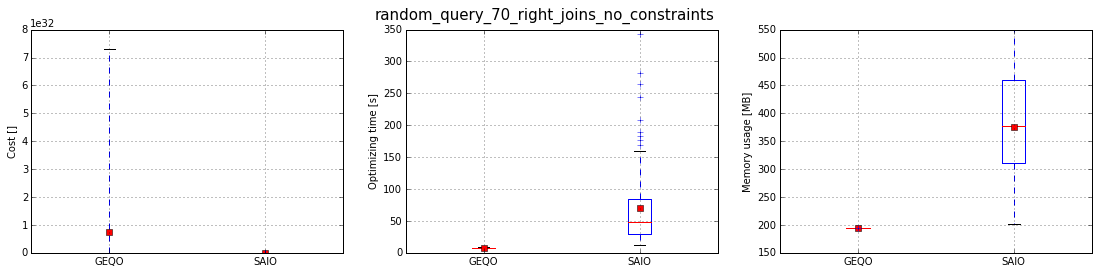

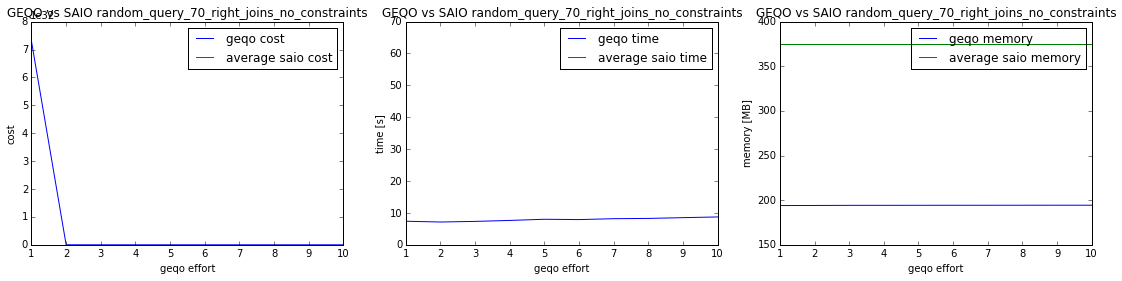

99


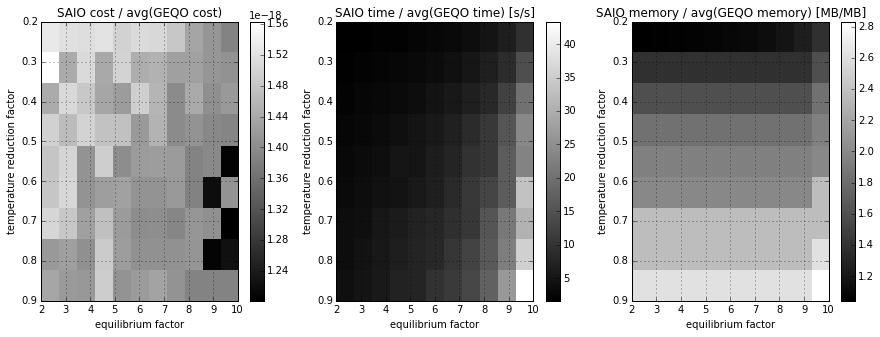

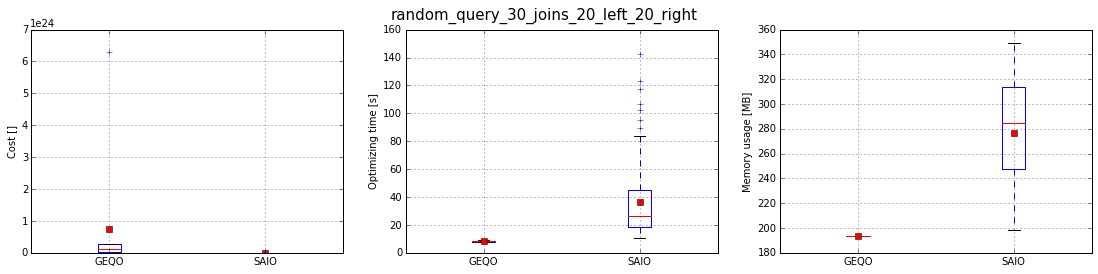

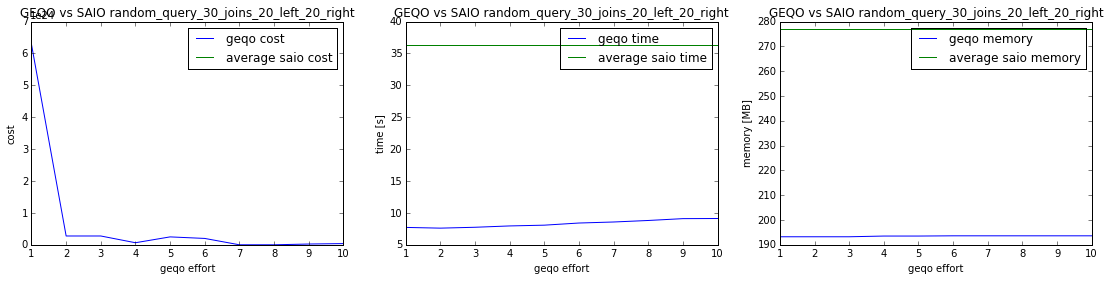

99


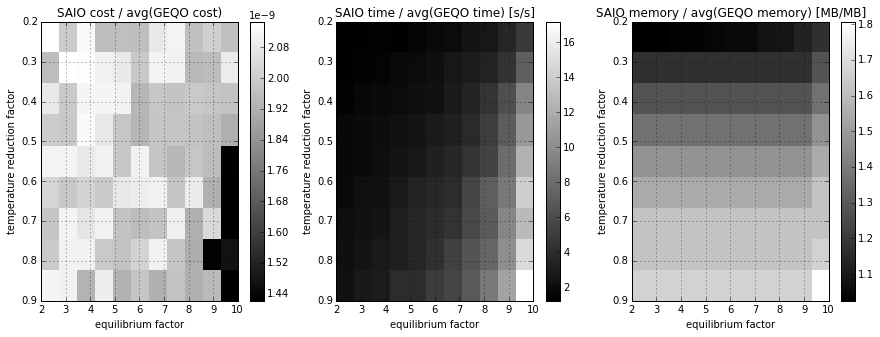

In [14]:
display_info_for_test_case('random_query_70_joins_no_constraints')
display_info_for_test_case('random_query_70_left_joins_no_constraints')
display_info_for_test_case('random_query_70_right_joins_no_constraints')
display_info_for_test_case('random_query_30_joins_20_left_20_right')

####100 JOINS

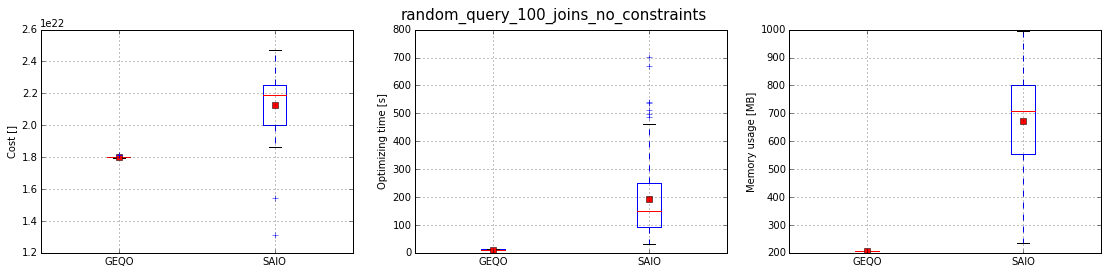

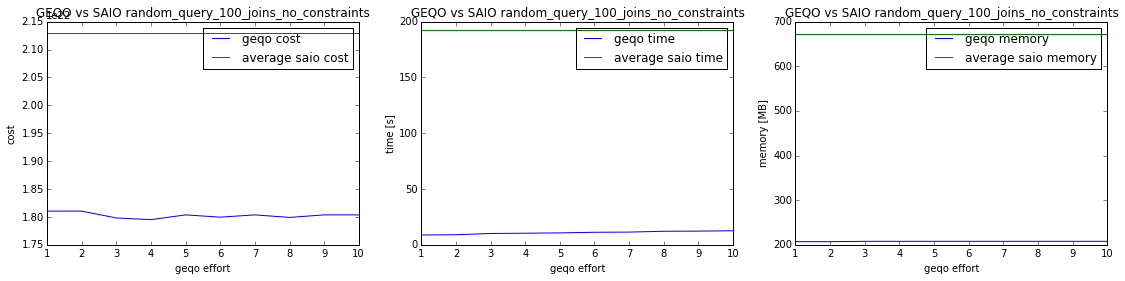

99


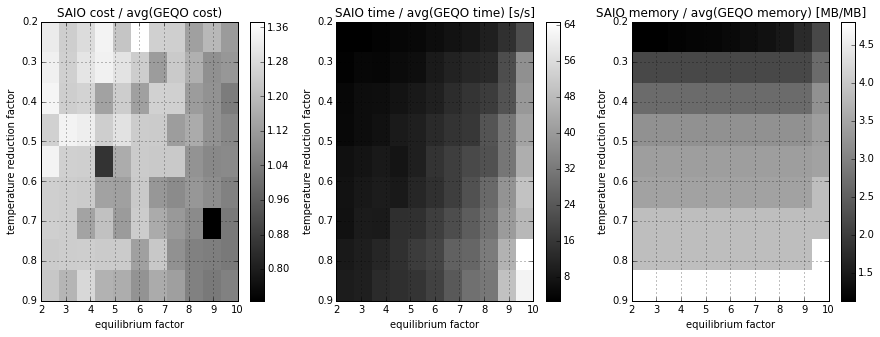

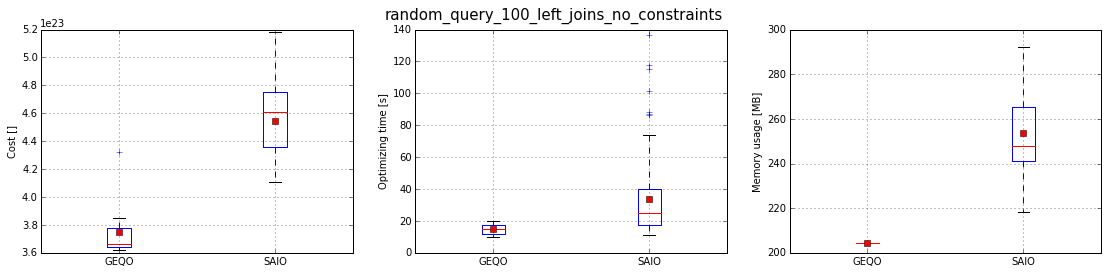

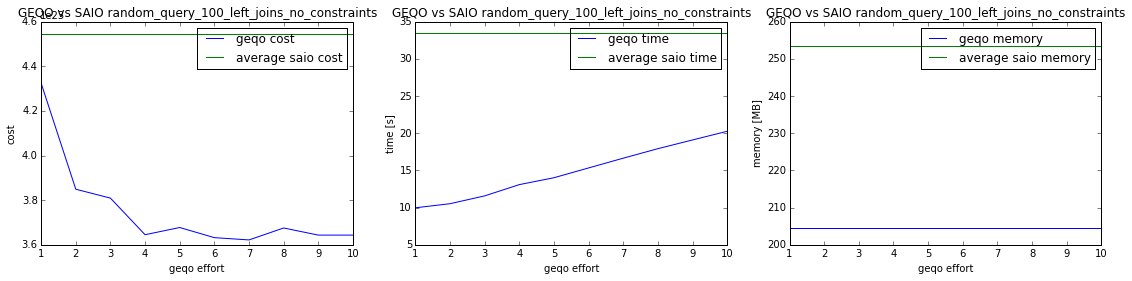

99


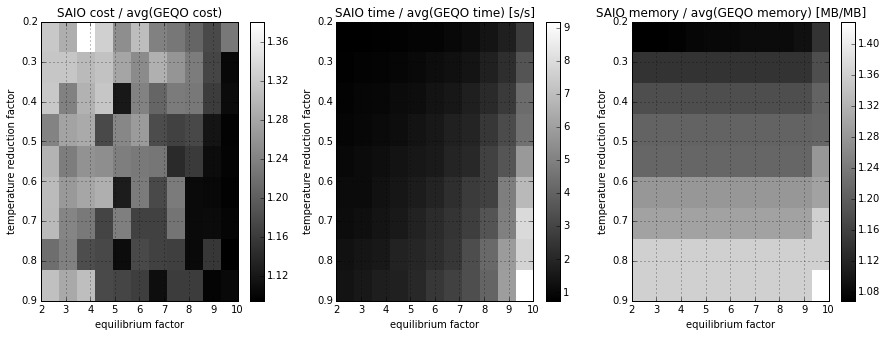

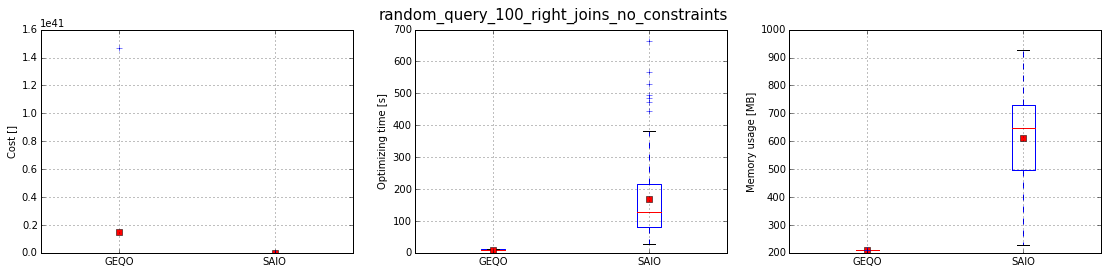

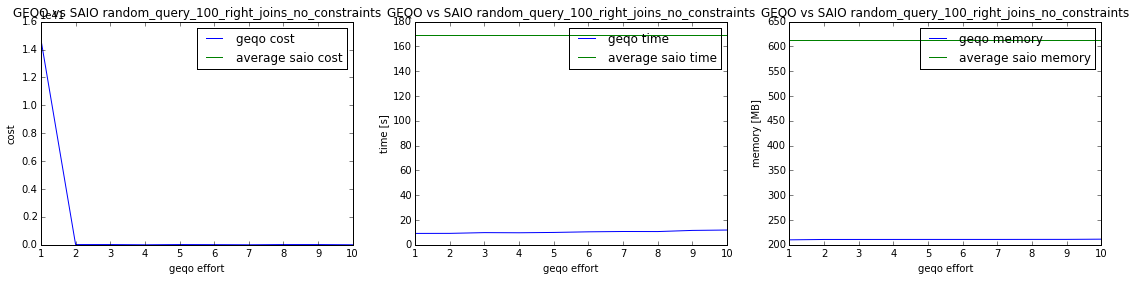

99


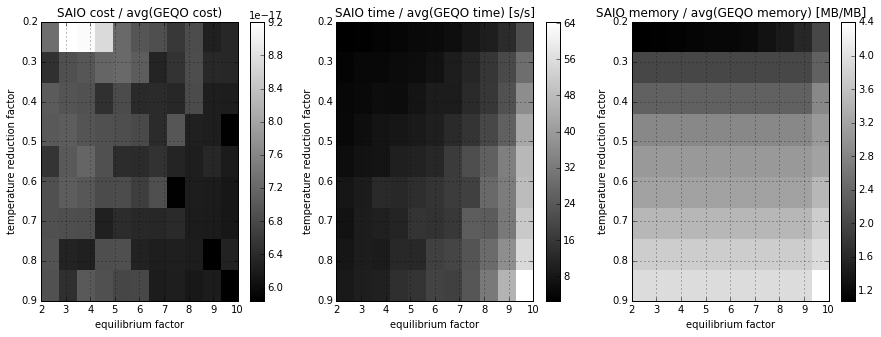

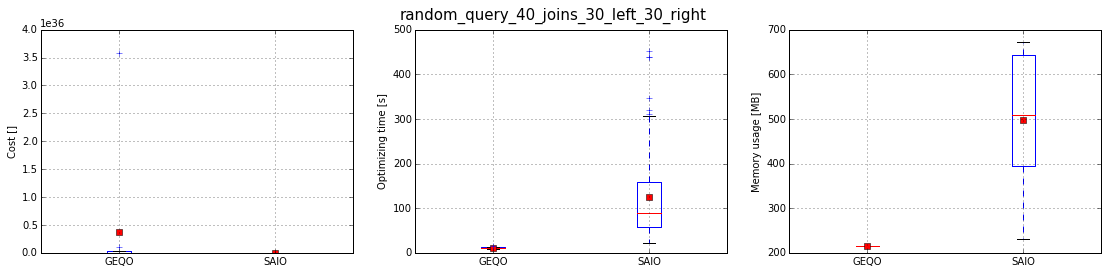

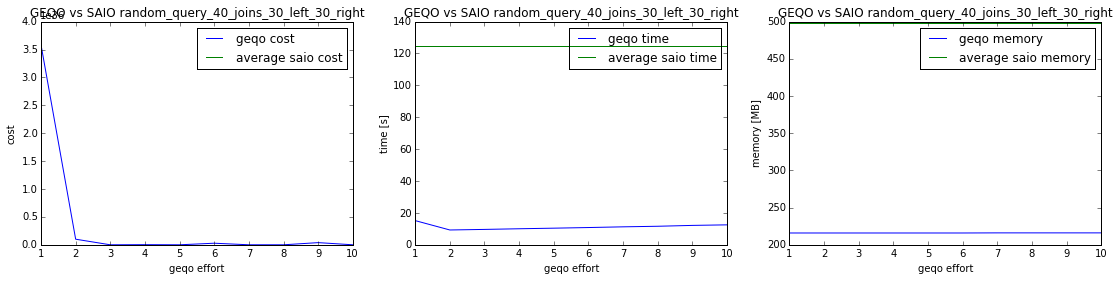

99


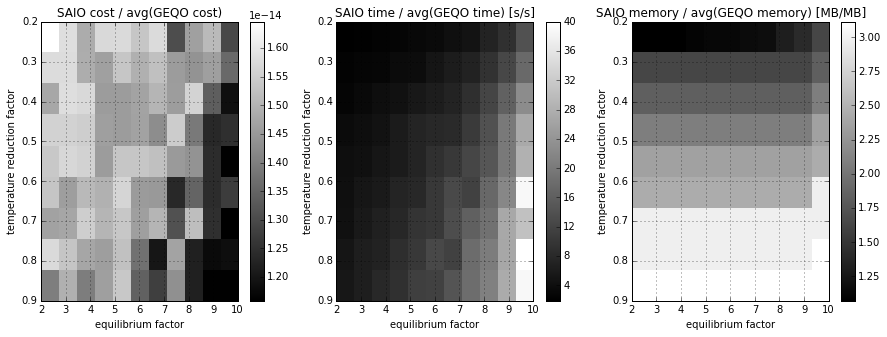

In [15]:
display_info_for_test_case('random_query_100_joins_no_constraints')
display_info_for_test_case('random_query_100_left_joins_no_constraints')
display_info_for_test_case('random_query_100_right_joins_no_constraints')
display_info_for_test_case('random_query_40_joins_30_left_30_right')

####130 joins

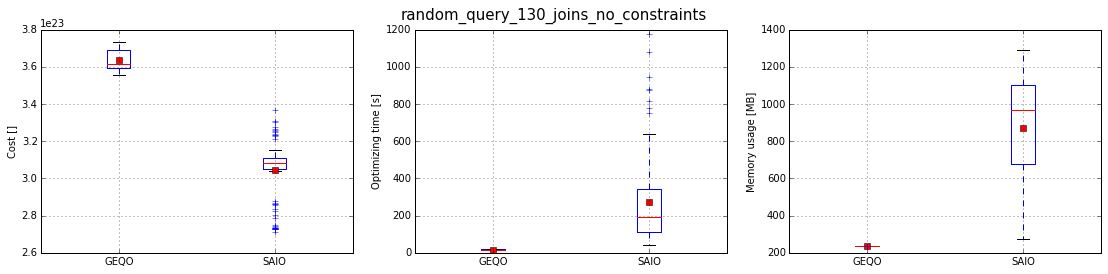

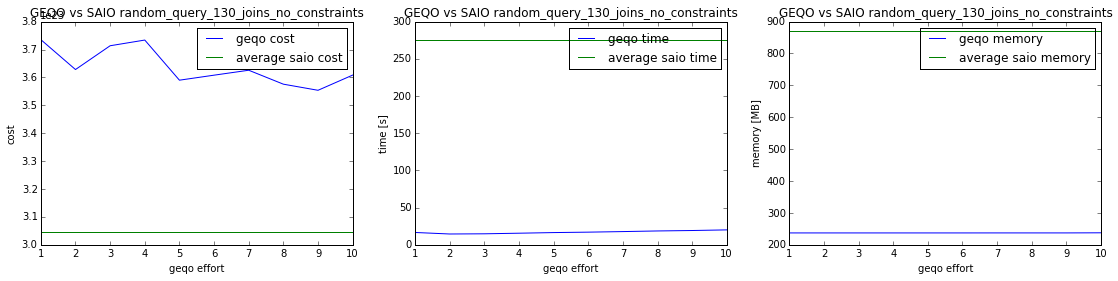

99


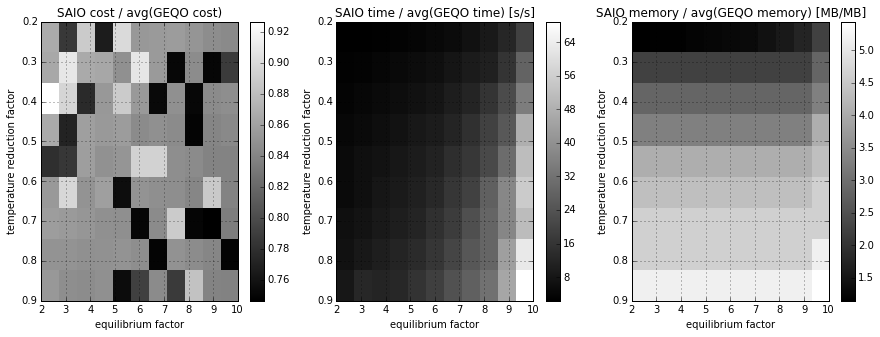

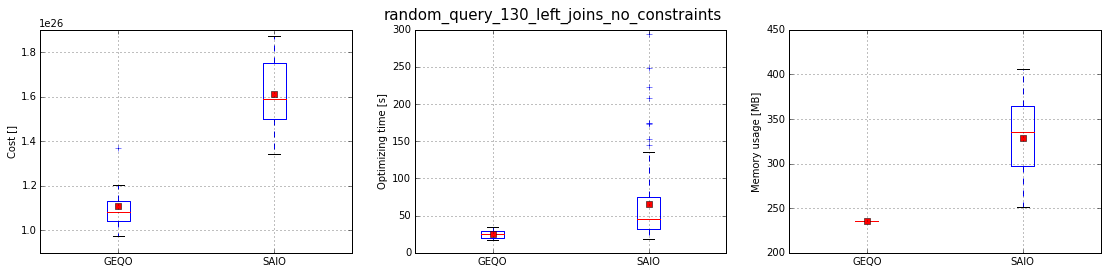

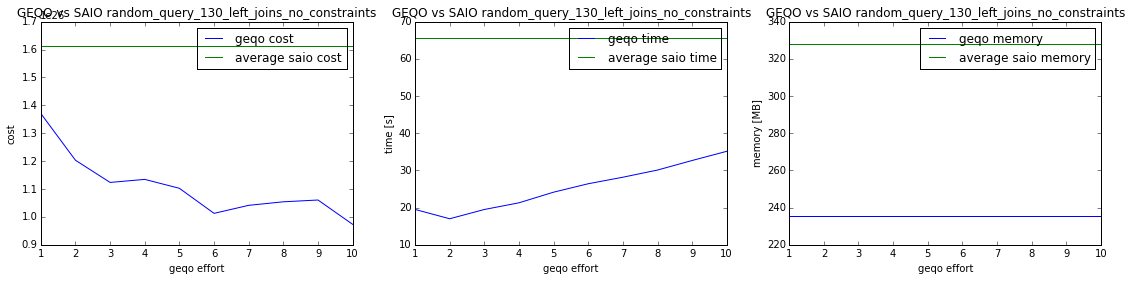

99


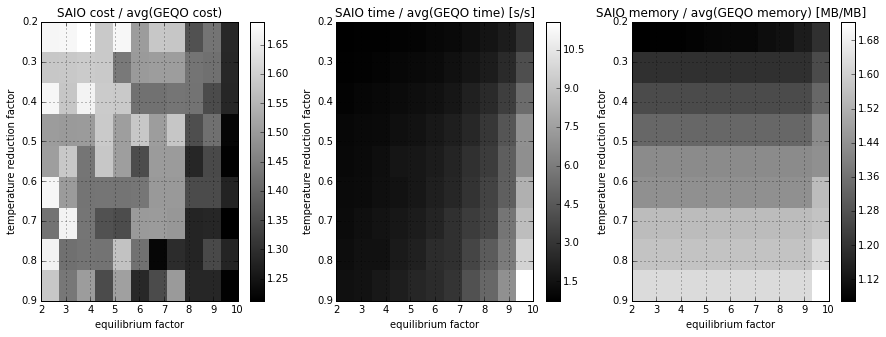

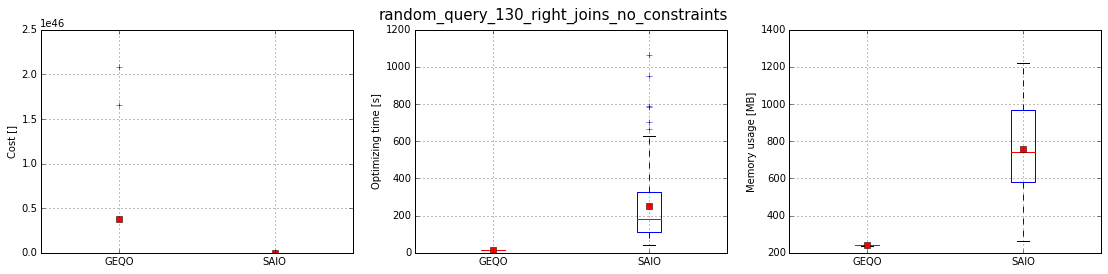

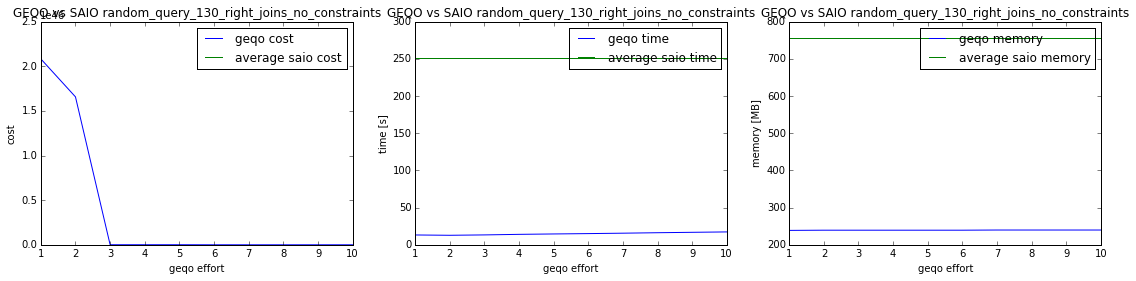

99


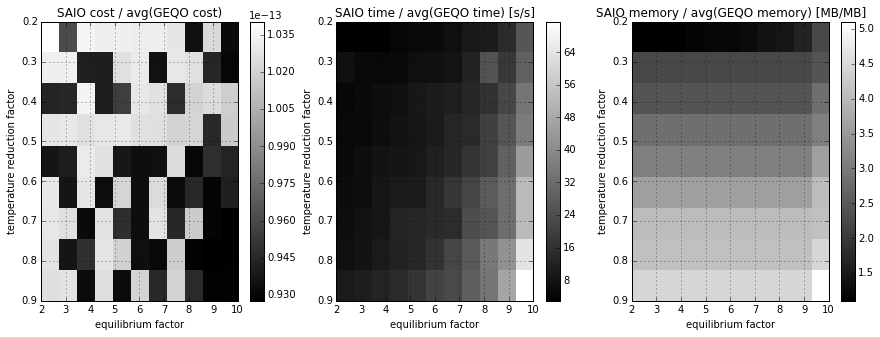

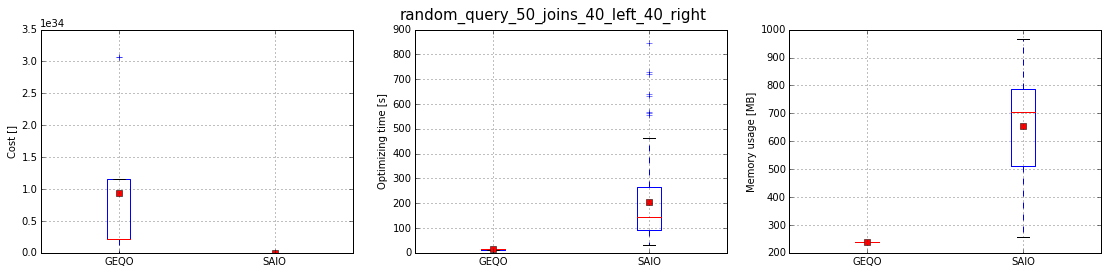

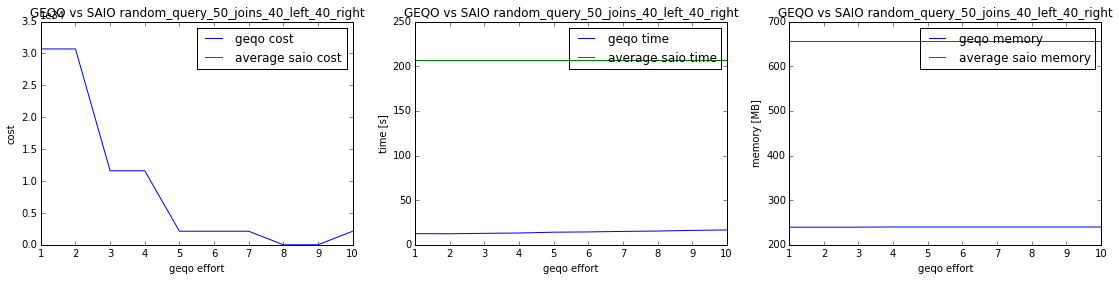

99


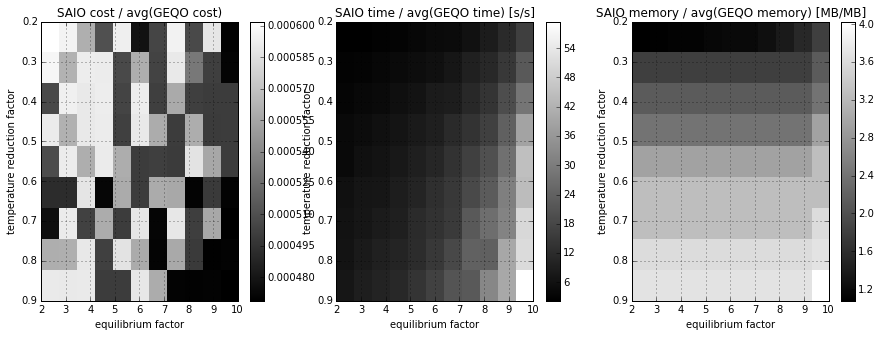

In [16]:
display_info_for_test_case('random_query_130_joins_no_constraints')
display_info_for_test_case('random_query_130_left_joins_no_constraints')
display_info_for_test_case('random_query_130_right_joins_no_constraints')
display_info_for_test_case('random_query_50_joins_40_left_40_right')

### nested queries

15 JOINS (JOINS, LEFT JOINS, RIGHT JOINS)

20 JOINS

30 JOINS

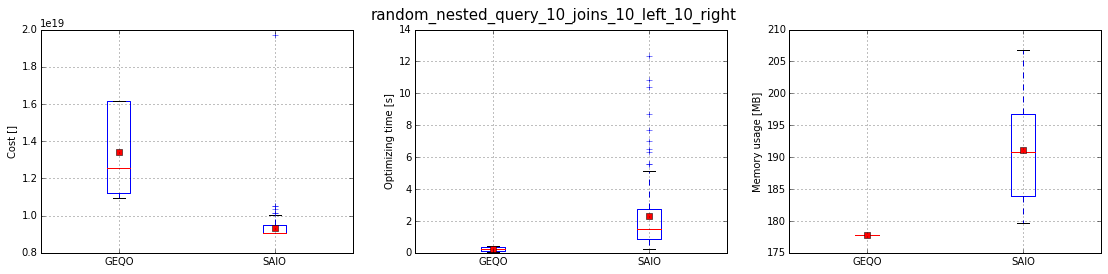

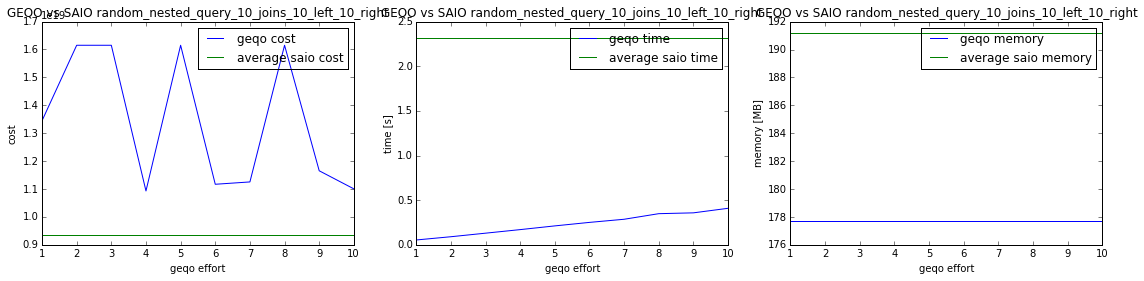

99


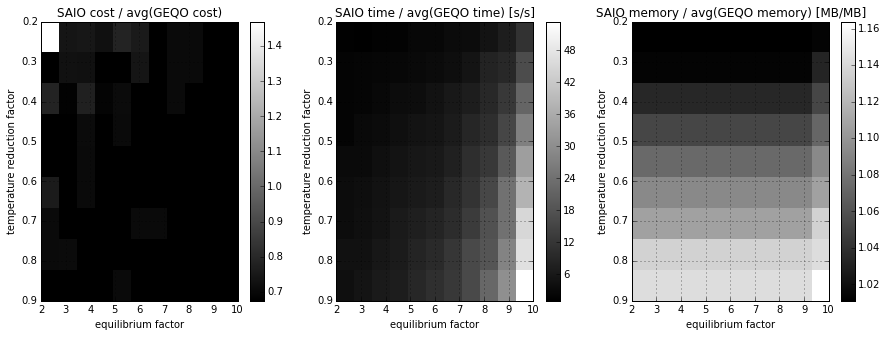

In [19]:
display_info_for_test_case('random_nested_query_10_joins_10_left_10_right')

50 joins

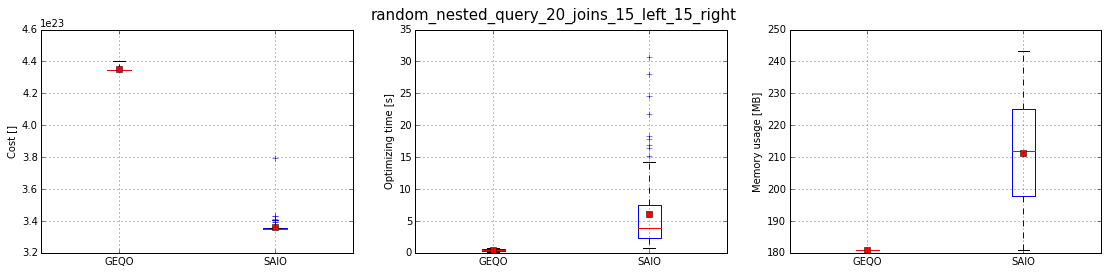

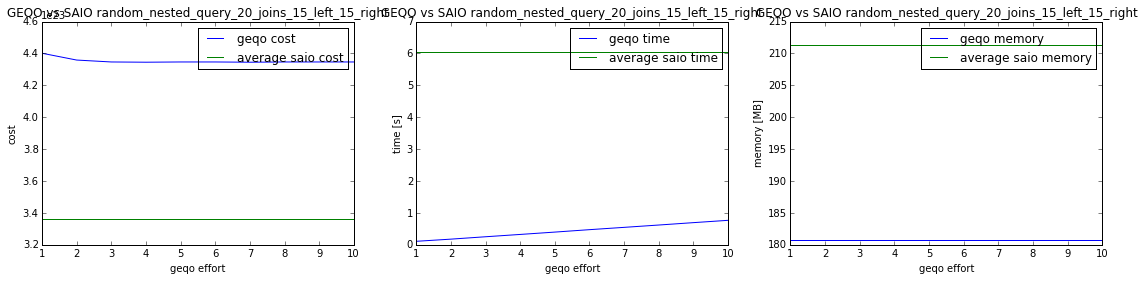

99


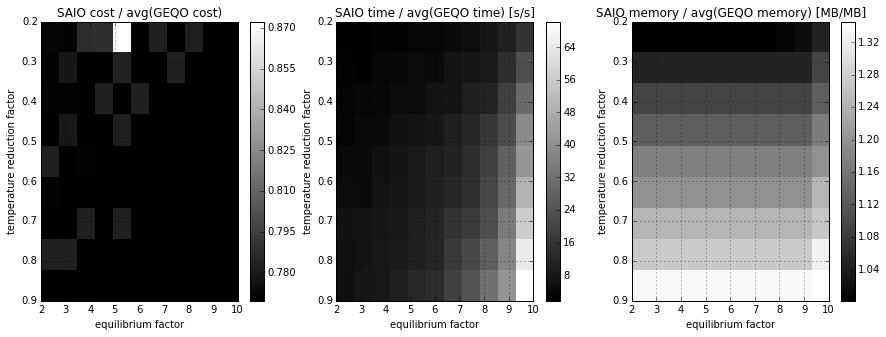

In [22]:
display_info_for_test_case('random_nested_query_20_joins_15_left_15_right')

80 LEFT JOINS

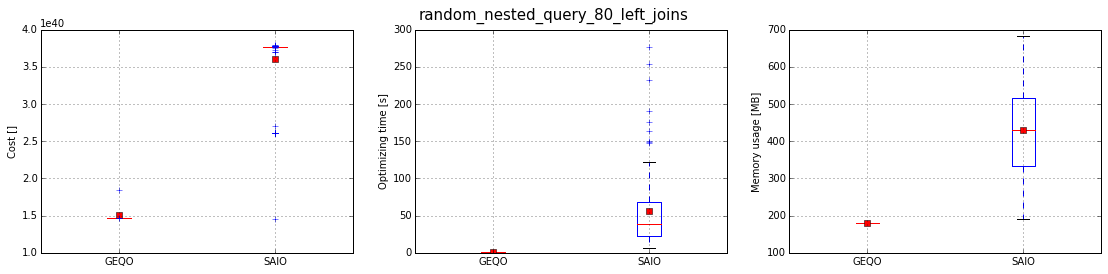

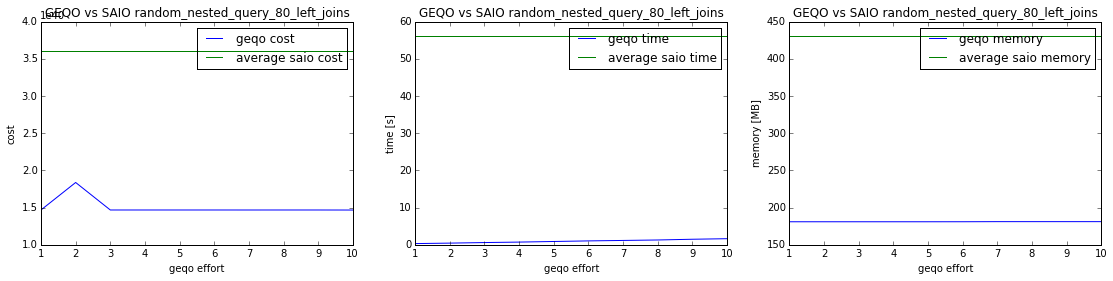

99


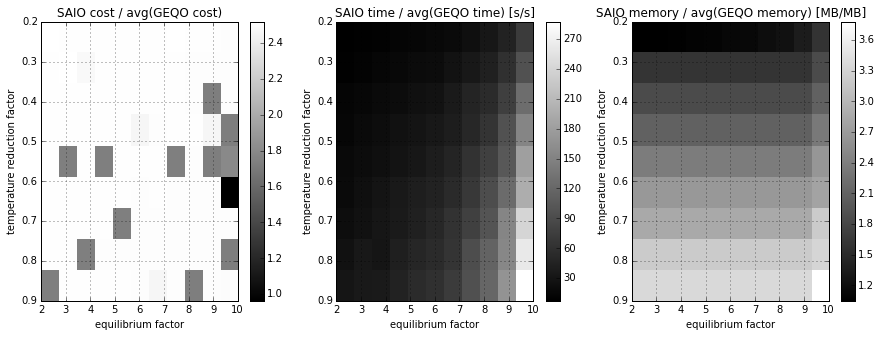

In [21]:
display_info_for_test_case('random_nested_query_80_left_joins')

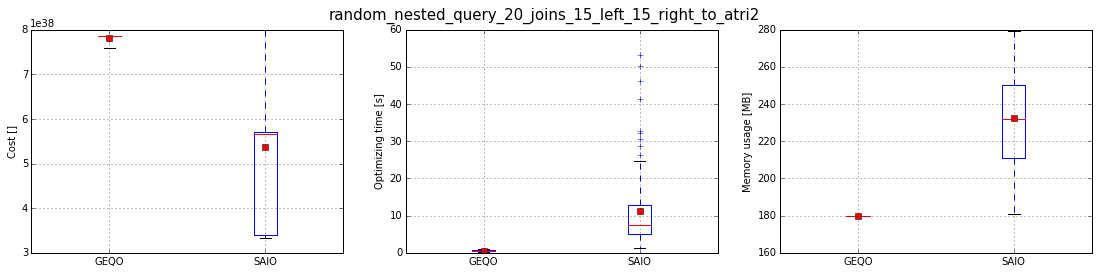

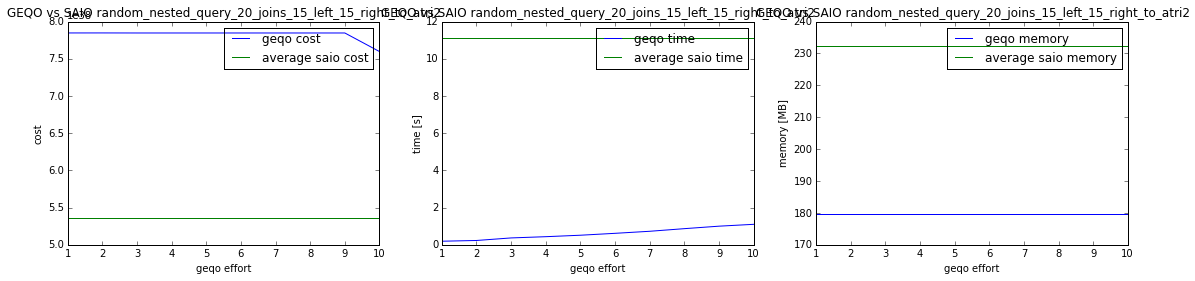

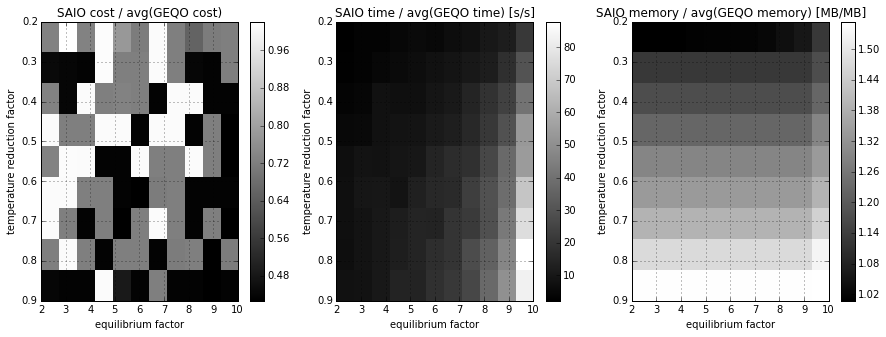

In [24]:
display_info_for_test_case('random_nested_query_20_joins_15_left_15_right_to_atri2')